## Import libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import style
from Linear_Regression.models.linear_regression import LinearRegression as LR
from Linear_Regression.models.regression_metrics import RegressionMetrics
from Linear_Regression.models.standard_scaler import StandardScaler as SC
from Polynomial_Regression.models.polynomial_features import PolynomialFeatures as PF
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from matplotlib.colors import LinearSegmentedColormap

## Set the style and display options

In [2]:
style.use("dark_background")

pd.set_option("display.max_columns", 500)
pd.set_option("expand_frame_repr", False)


## Load and inspect the dataset

In [3]:
df = pd.read_csv("../data/manufacturing.csv")

print(df.head())
print(df.info())

   Temperature (°C)  Pressure (kPa)  Temperature x Pressure  Material Fusion Metric  Material Transformation Metric  Quality Rating
0        209.762701        8.050855             1688.769167            44522.217074                    9.229576e+06       99.999971
1        243.037873       15.812068             3842.931469            63020.764997                    1.435537e+07       99.985703
2        220.552675        7.843130             1729.823314            49125.950249                    1.072839e+07       99.999758
3        208.976637       23.786089             4970.736918            57128.881547                    9.125702e+06       99.999975
4        184.730960       15.797812             2918.345014            38068.201283                    6.303792e+06      100.000000
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3957 entries, 0 to 3956
Data columns (total 6 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          ----

## Inspect target variable - Quality Rating

In [4]:
print(f"Quality Rating is between {df["Quality Rating"].min()} and {df["Quality Rating"].max()}")

Quality Rating is between 1.0 and 100.0


## Setup pyplot styles

In [5]:
plt.rcParams["figure.figsize"] = (16,8)
plt.rcParams["figure.titlesize"] = 28
plt.rcParams["axes.titlesize"] = 18
plt.rcParams["axes.labelsize"] = 12
plt.rcParams["legend.fontsize"] = 12

## Distribution of manufacturing data

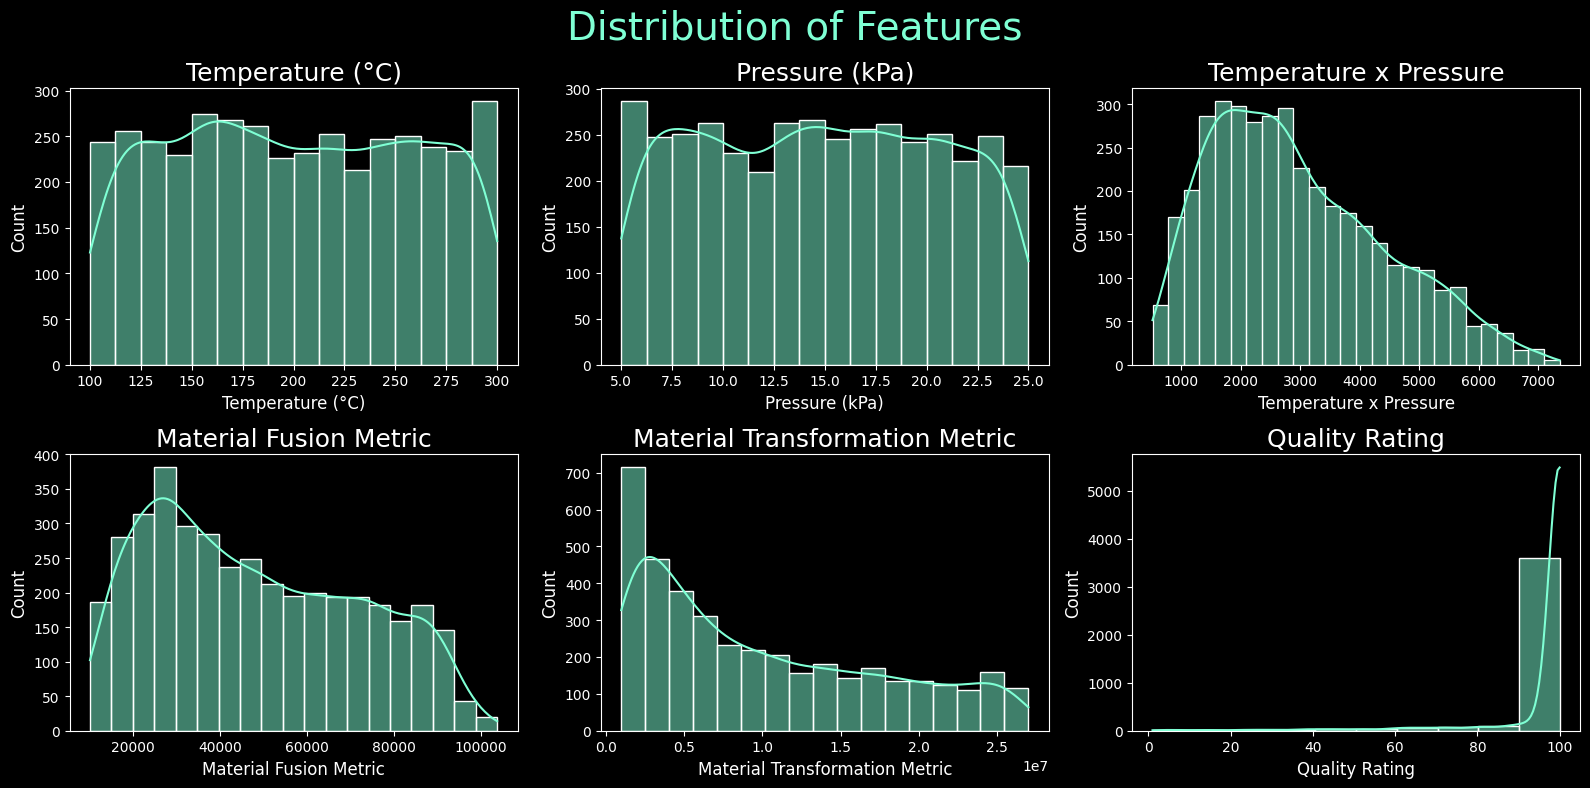

In [6]:
plt.suptitle("Distribution of Features", color="aquamarine")

for index, column in enumerate(df.columns):
    plt.subplot(2, 3, index+1)
    plt.xlabel(xlabel=column)
    plt.ylabel(ylabel="Count")
    plt.title(label=column)

    if column == "Quality Rating":
        sns.histplot(data=df, x=column, bins=10, color="aquamarine", kde=True)
    else:
        sns.histplot(data=df, x=column, color="aquamarine", kde=True)

plt.tight_layout()

## Feature vs Quality Rating

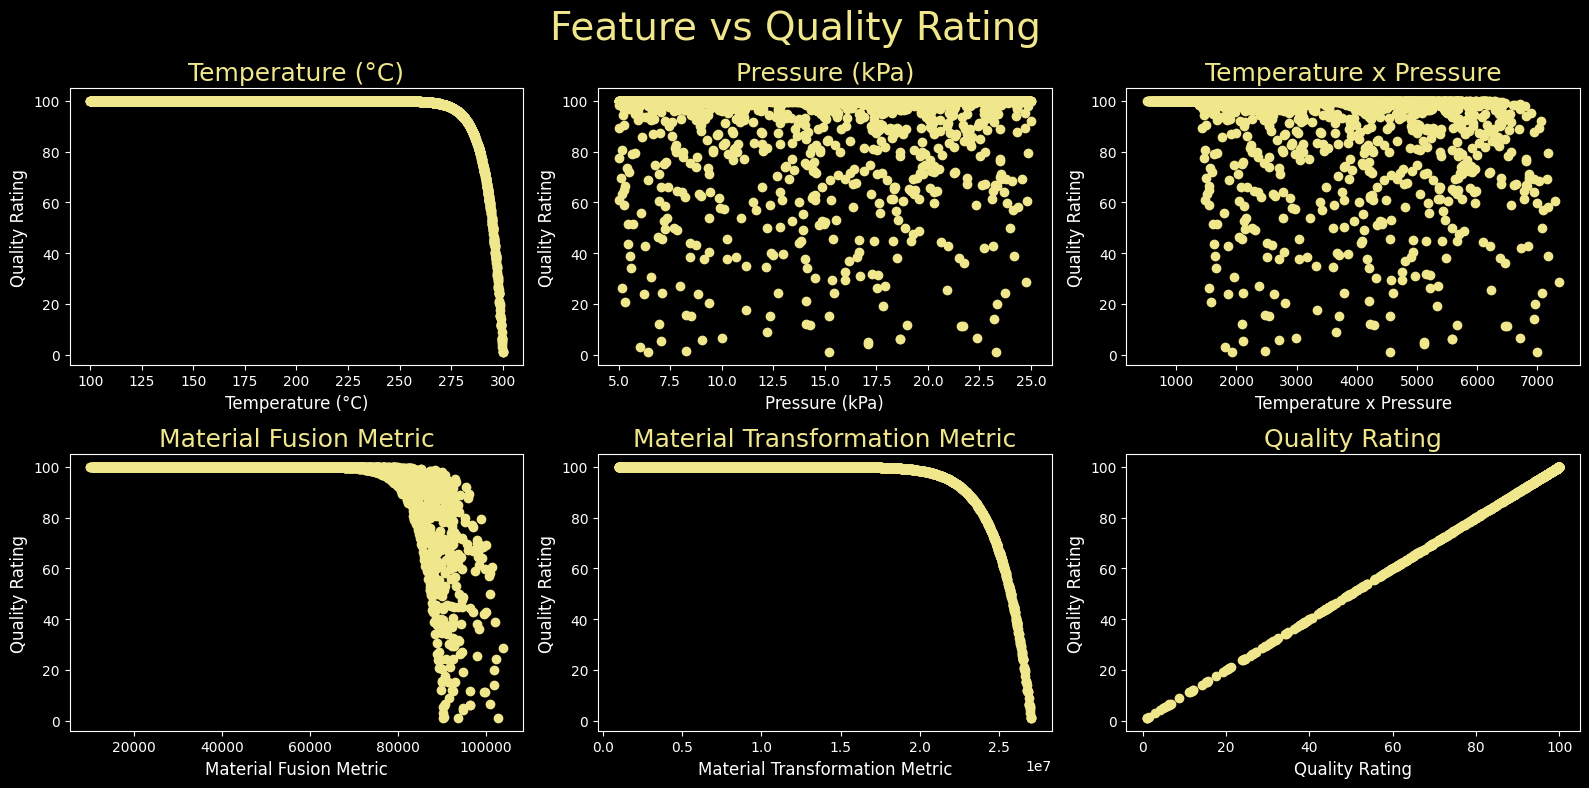

In [7]:
plt.suptitle("Feature vs Quality Rating", color="khaki")

for index, column in enumerate(df.columns):
    plt.subplot(2, 3, index+1)
    plt.scatter(df[column], df["Quality Rating"], c="khaki")
    plt.title(label=column, color="khaki")
    plt.xlabel(xlabel=column)
    plt.ylabel(ylabel="Quality Rating")

plt.tight_layout()
    

**Material Fusion Metric**, **Material Transformation Metric** and **Temperature** have a high influence on **Quality Rating**

## Correlation between features and Quality Rating

In [8]:
cmap = LinearSegmentedColormap.from_list("custom_colormap", colors=["goldenrod", "white", "lightseagreen"], N=1000)

In [9]:
def heatmap_features_target(df, cmap):
    correlation_matrix = df.corr()[["Quality Rating"]]
    correlation_matrix["absolute_corr"] = abs(correlation_matrix)

    heatmap = sns.heatmap(correlation_matrix.drop(index="Quality Rating")
                          .sort_values(by="absolute_corr", ascending=False)
                          .drop(columns=["absolute_corr"]), 
                        annot=True, annot_kws={"fontsize": 15, "weight": "bold"}, cmap=cmap)
    heatmap.set_title("Features Correlating with Quality Rating", fontsize=28)
    heatmap.set_xticklabels(heatmap.get_xticklabels(), fontsize=15)
    heatmap.set_yticklabels(heatmap.get_yticklabels(), fontsize=15, rotation=0)
    plt.tight_layout()

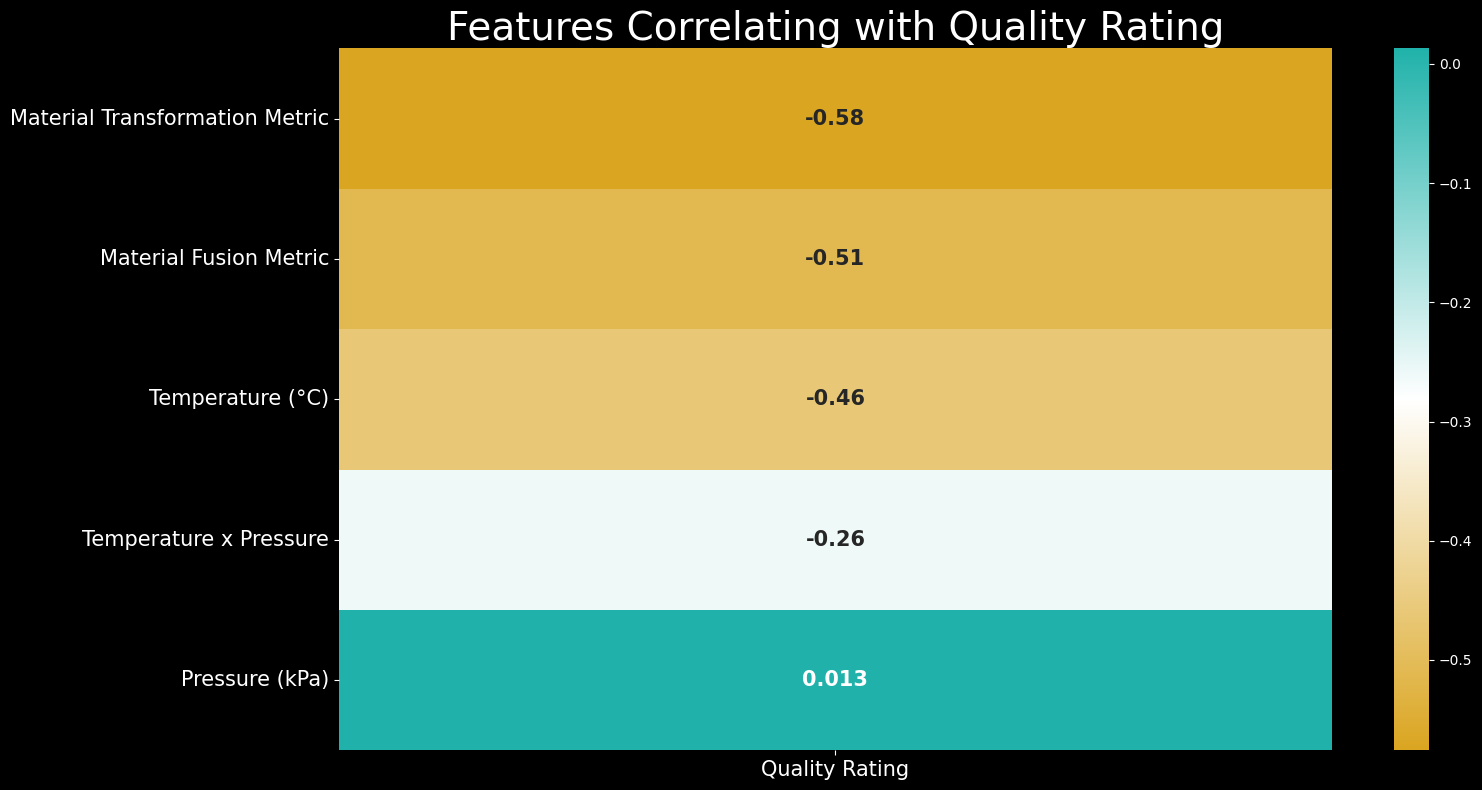

In [10]:
heatmap_features_target(df, cmap)

**Material Fusion Metric**, **Material Transformation Metric** and **Temperature** have the highest correlation with **Quality Rating**

## Split the data into features and target variable

In [11]:
X = df.drop(columns=["Quality Rating"]).values
y = df["Quality Rating"].values

## Split the data into training and testing sets

In [12]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

## Standardize the features using custom and sklearn scalers

In [13]:
sc_custom = SC()
X_train_custom = sc_custom.fit_transform(X_train)
X_test_custom = sc_custom.transform(X_test)

In [14]:
sc_sklearn = StandardScaler()
X_train_sklearn = sc_sklearn.fit_transform(X_train)
X_test_sklearn = sc_sklearn.transform(X_test)

## Create metrics arrays for Custom and Sklearn models to compare different polynomial degrees

In [15]:
maes_custom = []
mses_custom = []
rmses_custom = []
r2_custom = []
preds_custom = []

maes_sklearn = []
mses_sklearn = []
rmses_sklearn = []
r2_sklearn = []
preds_sklearn = []

degrees = 11

for degree in range(1, degrees):
    pf_custom = PF(degree=degree)
    X_train_pf_custom = pf_custom.fit_transform(X_train_custom)
    X_test_pf_custom = pf_custom.transform(X_test_custom)

    pf_sklearn = PolynomialFeatures(degree=degree)
    X_train_pf_sklearn = pf_sklearn.fit_transform(X_train_sklearn)
    X_test_pf_sklearn = pf_sklearn.transform(X_test_sklearn)

    lr_custom = LR()
    lr_custom.fit(X_train_pf_custom, y_train)
    pred_custom = lr_custom.predict(X_test_pf_custom)
    preds_custom.append(pred_custom)

    lr_sklern = LinearRegression()
    lr_sklern.fit(X_train_pf_sklearn, y_train)
    pred_sklearn = lr_sklern.predict(X_test_pf_sklearn)
    preds_sklearn.append(pred_sklearn)


    maes_custom.append(RegressionMetrics.MAE(y_true=y_test, y_pred=pred_custom))
    mses_custom.append(RegressionMetrics.MSE(y_true=y_test, y_pred=pred_custom))
    rmses_custom.append(RegressionMetrics.RMSE(y_true=y_test, y_pred=pred_custom))
    r2_custom.append(RegressionMetrics.R2(y_true=y_test, y_pred=pred_custom))

    maes_sklearn.append(mean_absolute_error(y_true=y_test, y_pred=pred_sklearn))
    mses_sklearn.append(mean_squared_error(y_true=y_test, y_pred=pred_sklearn))
    rmses_sklearn.append(np.sqrt(mean_squared_error(y_true=y_test, y_pred=pred_sklearn)))
    r2_sklearn.append(r2_score(y_true=y_test, y_pred=pred_sklearn))

## Create models array to represent each model errors, scores and plot characteristics

In [16]:
models = [
    {
        "model": lr_custom,
        "maes": maes_custom,
        "mses": mses_custom,
        "rmses": rmses_custom,
        "r2": r2_custom,
        "title": "Custom",
        "y_preds": preds_custom,
        "color": "aquamarine",
        "edgecolor": "aquamarine",
        "scattercolor": "darkslategrey"
        
    },
    {
        "model": lr_sklern,
        "maes": maes_sklearn,
        "mses": mses_sklearn,
        "rmses": rmses_sklearn,
        "r2": r2_sklearn,
        "title": "Sklearn",
        "y_preds": preds_sklearn,
        "color": "khaki",
        "edgecolor": "khaki",
        "scattercolor": "sienna"

    }
]


In [17]:
metrics = [
    {
        "name": "maes",
        "title": "Mean Absolute Error",
    },
    {
        "name": "mses",
        "title": "Mean Squared Error"
    },
    {
        "name": "rmses",
        "title": "Root Mean Squared Error",
    },
    {
        "name": "r2",
        "title": "R^2 Score"
    },
]

## Update models with extrema metrics points 

In [18]:
for model in models:
    for metric in metrics:
        measure = "max" if metric["name"] == "r2" else "min"
        func1 = min if measure == "min" else max
        func2 = np.argmin if measure == "min" else np.argmax
        model[f"{metric["name"]}_{measure}"] = func1(model[metric["name"]])
        model[f"{metric["name"]}_arg{measure}"] = func2(model[metric["name"]])

## Plot and compare metrics between Custom and Sklearn models based on degree

In [19]:
def plot_metrics(metrics, models):
    for metric in metrics:
        plt.suptitle(t=metric["title"])
        for index, model in enumerate(models):
            measure = "max" if metric["name"] == "r2" else "min"

            plt.subplot(1, 2, index + 1)

            # Plot Metric line and scatter points
            plt.plot(range(1, degrees), model[metric["name"]], color=model["color"])
            plt.scatter(x=range(1, degrees), y=model[metric["name"]], s=100, edgecolors=model["edgecolor"], zorder=2,
                        linewidths=2, c=model["scattercolor"], marker="o")
            
            # Plot Extrems Point
            label = "Lowest Error" if measure == "min" else "Highest Score"
            plt.scatter(x=model[f"{metric["name"]}_arg{measure}"] + 1, y=model[f"{metric["name"]}_{measure}"], 
                        s=300, edgecolors=model["edgecolor"], zorder=2,
                        linewidths=2, c="purple", marker="o", label=label)
            
            # Adding Titles
            plt.title(label=f"{model["title"]} LR", color=model["color"])
            plt.xlabel(xlabel="Degree")
            plt.ylabel(ylabel=metric["title"])

            plt.legend(markerscale = 0.75)
        plt.show()

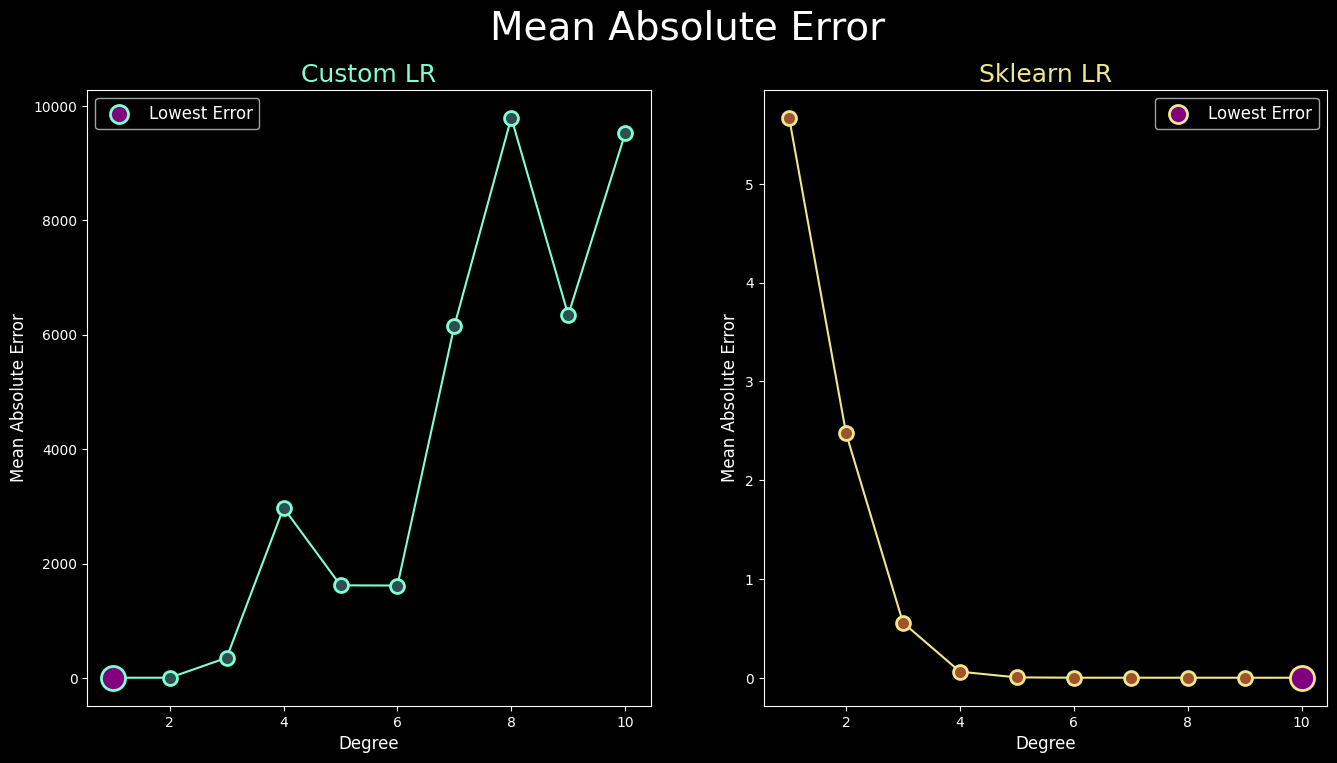

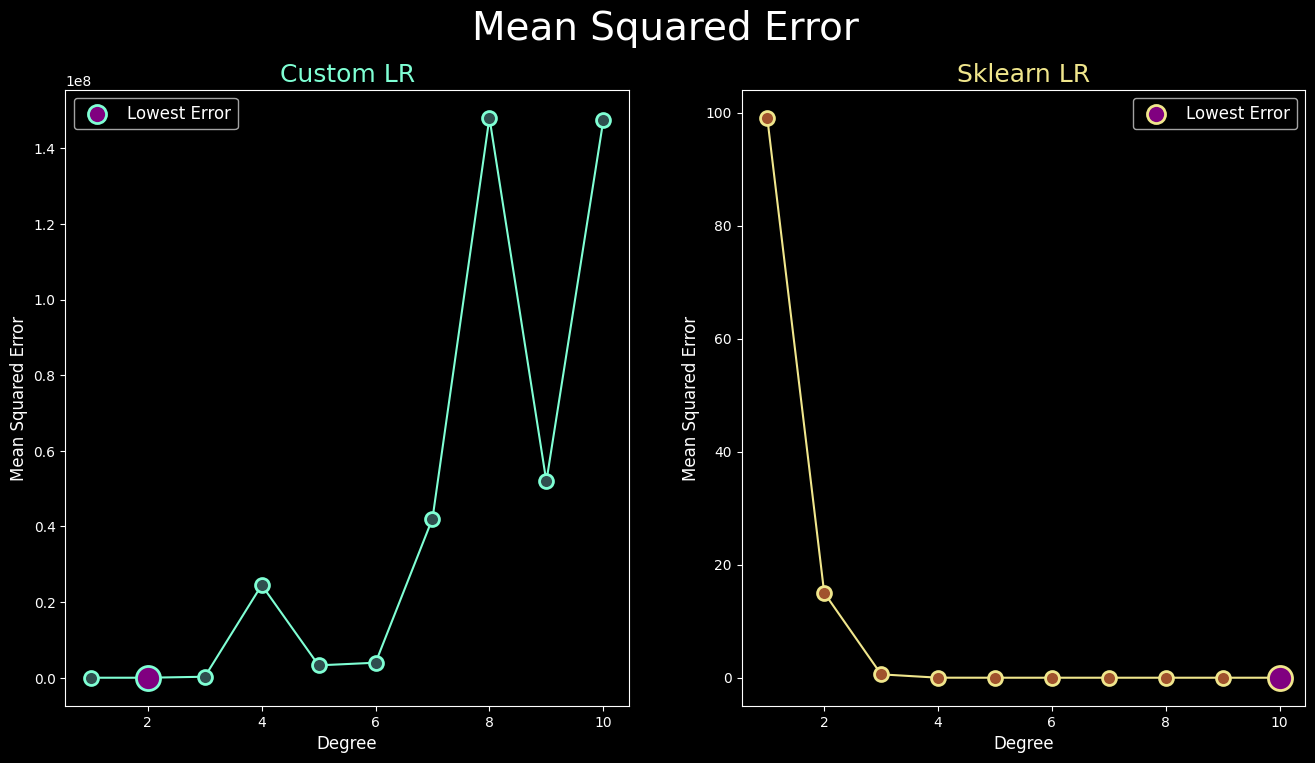

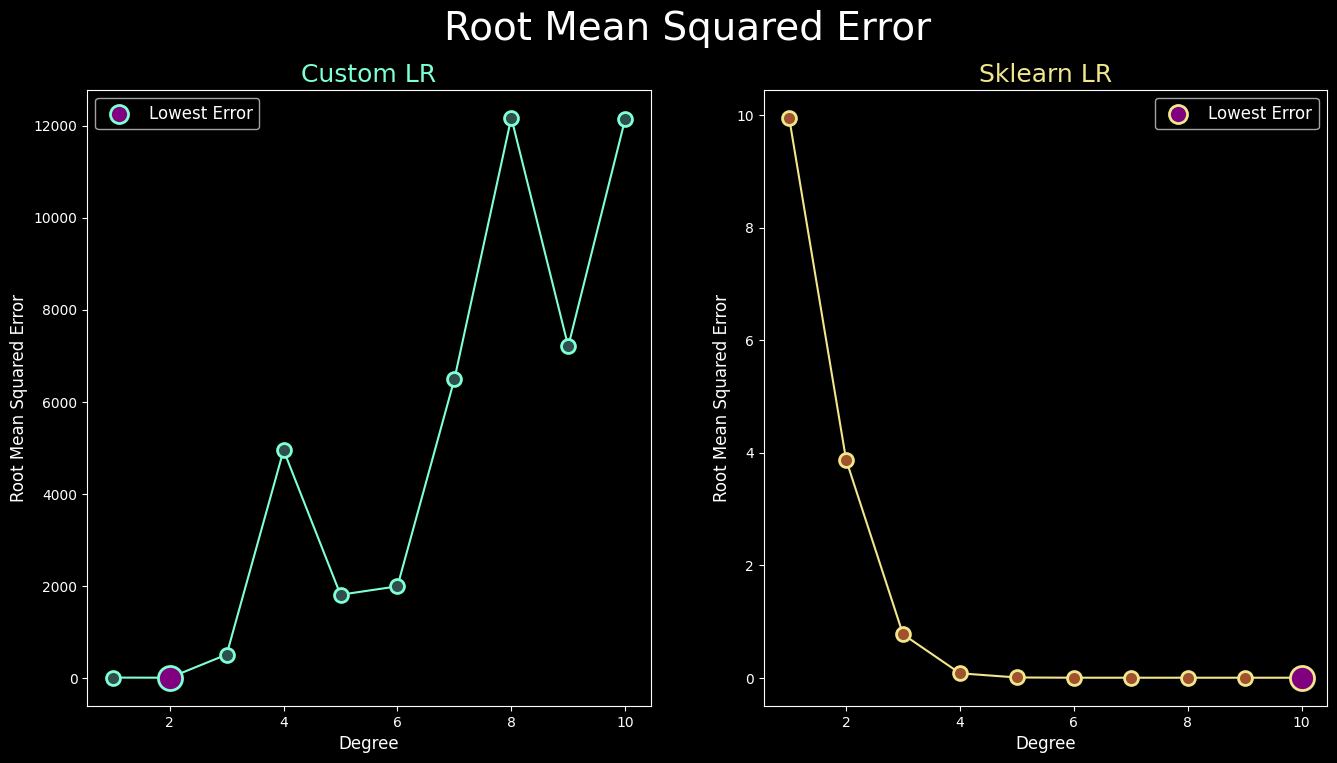

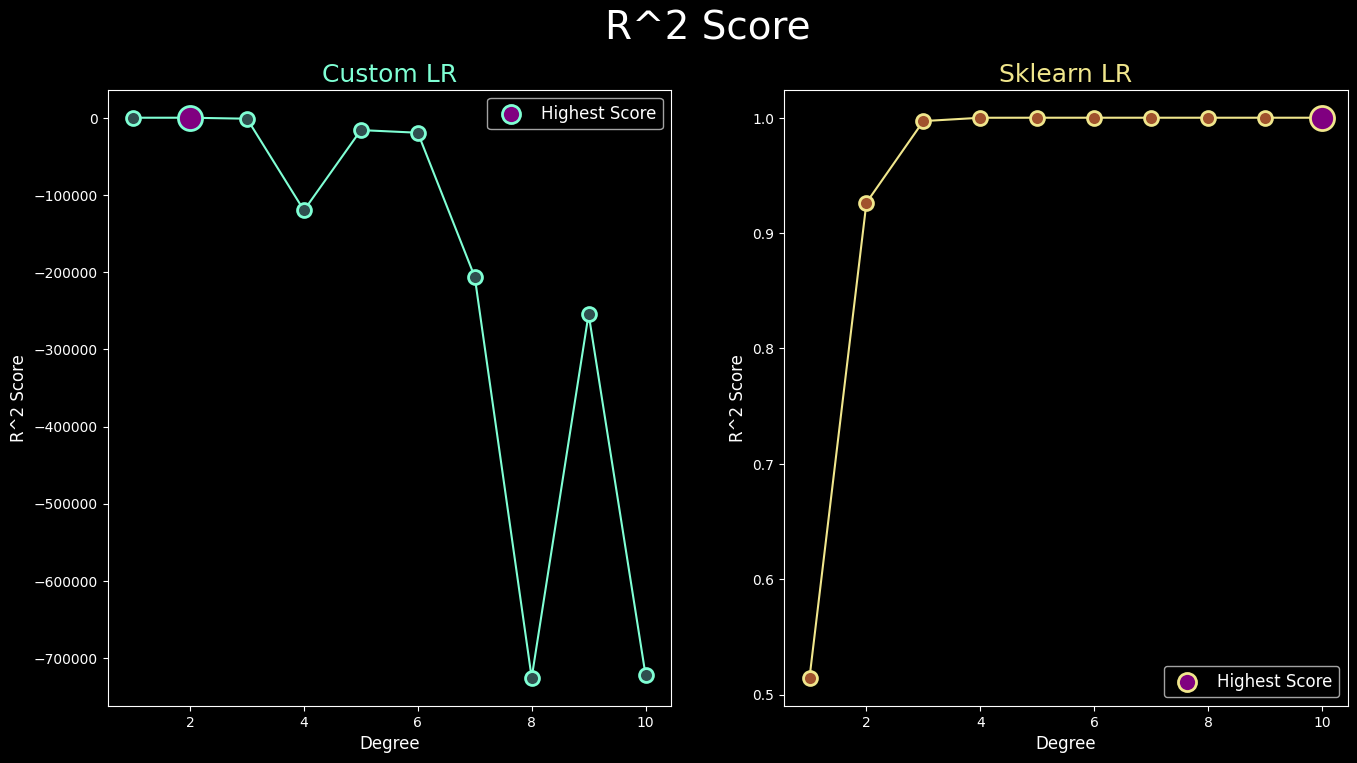

In [20]:
plot_metrics(metrics=metrics, models=models)

**Custom Model**:
 - Lowest errors and highest R^2 score are observed when polynomial degree = 2.

**Sklearn Model**:
 - With an increase of the polynomial degree there is an decrease in errors and increase in R^2 score. After polynomial degree = 4 there is no much difference in errors or R^2 score. Thus, for sake of simplicity and avoiding overfitting, degree = 4 could be chosen as the best polynomial degree for this dataset.

## Plot predictions vs true values for Custom and Sklearn models

This plot helps to visualize how well the model's predictions match the actual values. 
Ideally, the points should be close to a 45-degree line passing through the origin (y = x line), 
which would indicate perfect predictions. Deviations from this line indicate errors in the predictions.

In [21]:
def predictions_vs_targets(models, degree = None):
    if degree == None:
        nrows = 2
        ncols = int(degrees/2)

        for model in models:
            fig, ax = plt.subplots(nrows=nrows, ncols=ncols)
            fig.suptitle(t=f"{model["title"]} LR Predictions", color=model["color"])

            deg = 0
            for row in range(nrows):
                for column in range(ncols):
                    ax[row][column].set_title(label=f"Degree - {deg + 1}", color=model["color"])
                    if deg == 0:
                        ax[row][column].set_xlabel(xlabel="Predictions")
                        ax[row][column].set_ylabel(ylabel="Target Values")
                    
                    ax[row][column].scatter(x=model["y_preds"][deg], y=y_test, color=model["scattercolor"], edgecolor=model["edgecolor"])
                    deg = deg + 1
                    
            fig.tight_layout()
    else:
        plt.suptitle(t=f"Degree - {degree}")
        for index, model in enumerate(models):
            plt.subplot(1, 2, index + 1)
            plt.title(label=f"{model["title"]} LR", color=model["color"])
            plt.xlabel(xlabel="Predictions")
            plt.ylabel(ylabel="Target Values")
            plt.scatter(x=model["y_preds"][degree - 1], y=y_test, s=100,
                        color=model["scattercolor"], edgecolor=model["edgecolor"])
            plt.tight_layout()
        plt.show()

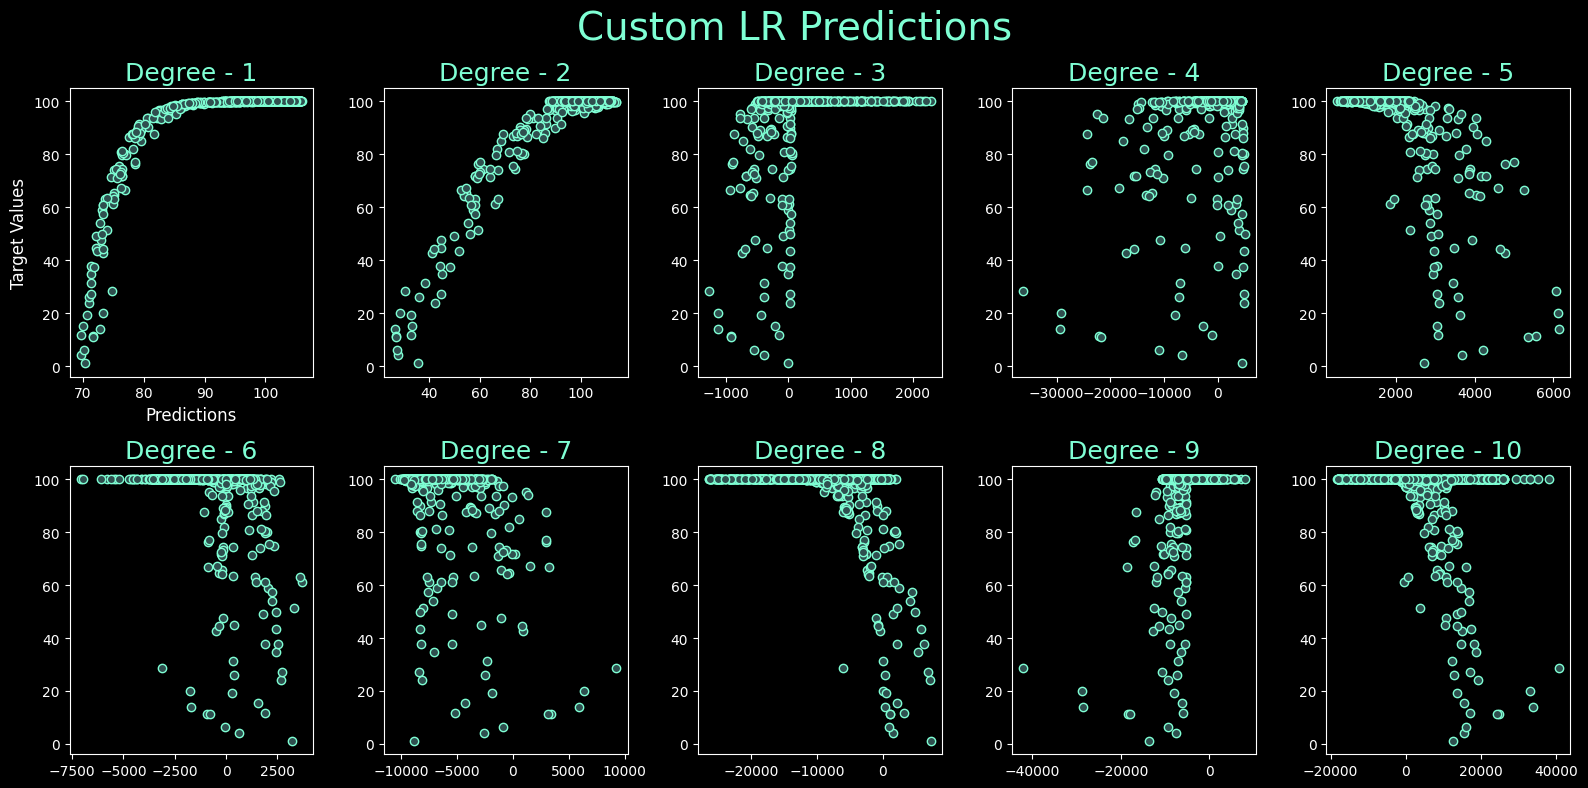

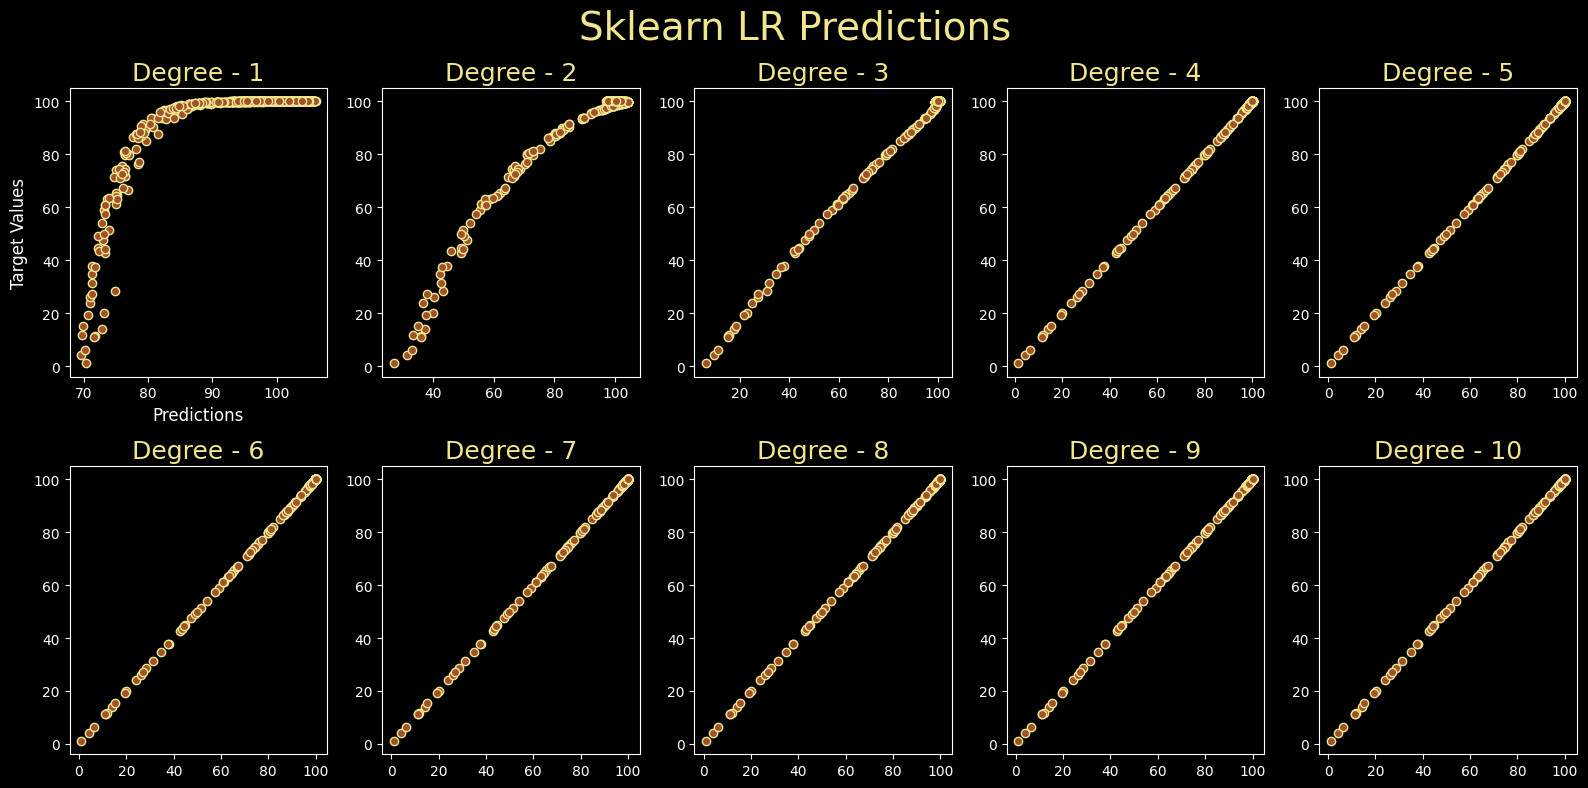

In [22]:
predictions_vs_targets(models=models)

**Custom Model**:
 - Most closest predictions to the actual values are observed when polynomial degree = 2.

**Sklearn Model**:
 - The higher the polynomial degree, the closer model predictions to the actual values are. After polynomial degree = 4 there is no significant difference between actual values and predictions of the model. Thus, for sake of simplicity and avoiding overfitting, degree = 4 could be chosen as the best polynomial degree for this dataset.

## Compare Models Predictions vs Targets by Specific Degree

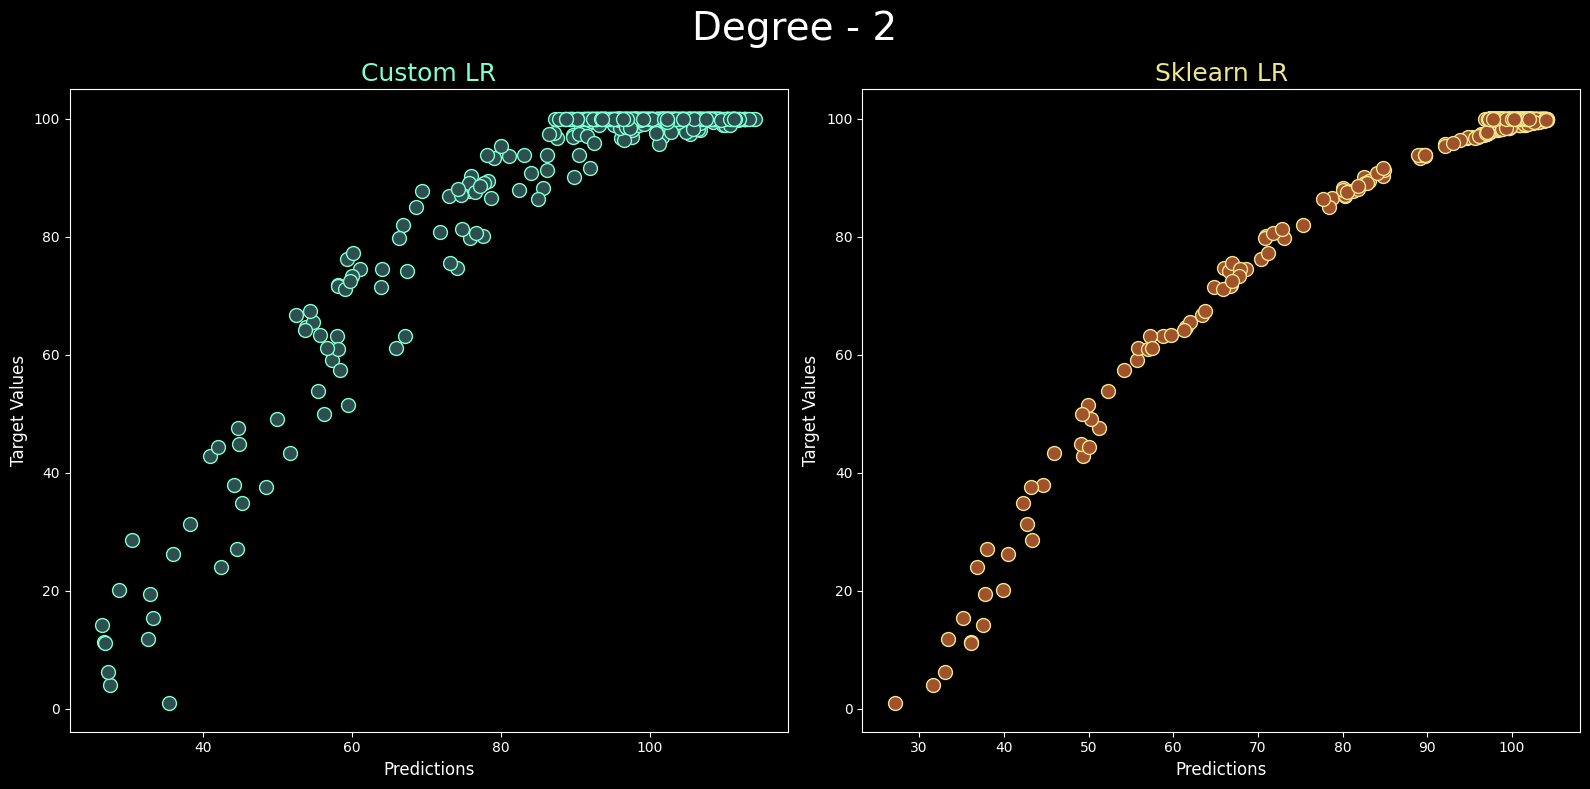

In [23]:
def compare_models(graph, models, degree):
    if graph == "predictions_vs_targets":
        predictions_vs_targets(models, degree)

predictions_vs_targets(models=models, degree=2)

## Linear Regression Assumptions

### Linearity
If the residuals are randomly scattered around the horizontal line (y=0) with no distinct patterns, this suggests that the linearity assumption is likely satisfied.

### Homoscedasticity (Constant Residual Variance)

The residuals should have constant variance across all levels of the predicted values. 
This can be assessed by plotting residuals vs fitted values and looking for a 'funnel' shape.
If the residuals spread out as the fitted values increase, it indicates heteroscedasticity.

### No Autocorrelation (Independent Error Terms)

The residuals should not show any pattern or correlation over time. 
This assumption is especially important for time series data. 
The residuals plot should show no clear pattern if this assumption is met.

In [24]:
degrees = 11

In [25]:
def predictions_vs_residuals(models, degree = None):
    if degree == None:
        nrows = 2
        ncols = int(degrees/nrows)
        deg = 0
        for model in models:
            fig, ax = plt.subplots(nrows=nrows, ncols=ncols)
            deg = 0
            for row in range(nrows):
                for column in range(ncols):
                    fig.suptitle(t=f"{model["title"]} LR Predictions vs Residuals", color=model["color"])

                    if deg == 0:
                        ax[row][column].set_xlabel(xlabel="Predictions")
                        ax[row][column].set_ylabel(ylabel="Residuals")
                    
                    residuals = y_test - model["y_preds"][deg]
                    ax[row][column].scatter(x=model["y_preds"][deg], y=residuals, c=model["scattercolor"], edgecolor=model["edgecolor"])

                    # Plot y=0
                    x_min, x_max = ax[row][column].get_xlim()
                    x = np.linspace(x_min, x_max, int((x_max - x_min) * 100))
                    y = [0] * int(((x_max - x_min) * 100))
                    ax[row][column].plot(x, y, linestyle="--", linewidth=2, color=model["color"])

                    # Set titles
                    ax[row][column].set_title(label=f"Degree - {deg + 1}", color=model["color"])

                    deg = deg + 1

            plt.tight_layout()
            plt.show()

    else:
        plt.suptitle(t=f"Degree - {degree}")
        for index, model in enumerate(models):
            plt.subplot(1, 2, index + 1)
            plt.title(label=f"{model["title"]} LR", color=model["color"])
            plt.xlabel(xlabel="Predictions")
            plt.ylabel(ylabel="Residuals")
            residuals = y_test - model["y_preds"][degree-1]
            plt.scatter(x=model["y_preds"][degree-1], y=residuals, s=100,
                        c=model["scattercolor"], edgecolors=model["edgecolor"])
            x_min, x_max = plt.xlim()
            x = np.linspace(x_min, x_max, int((x_max - x_min) * 100))
            y = [0] * int((np.abs(x_max - x_min) * 100))
            plt.plot(x, y, linestyle="--", linewidth=2, color=model["color"])
        
        plt.show()

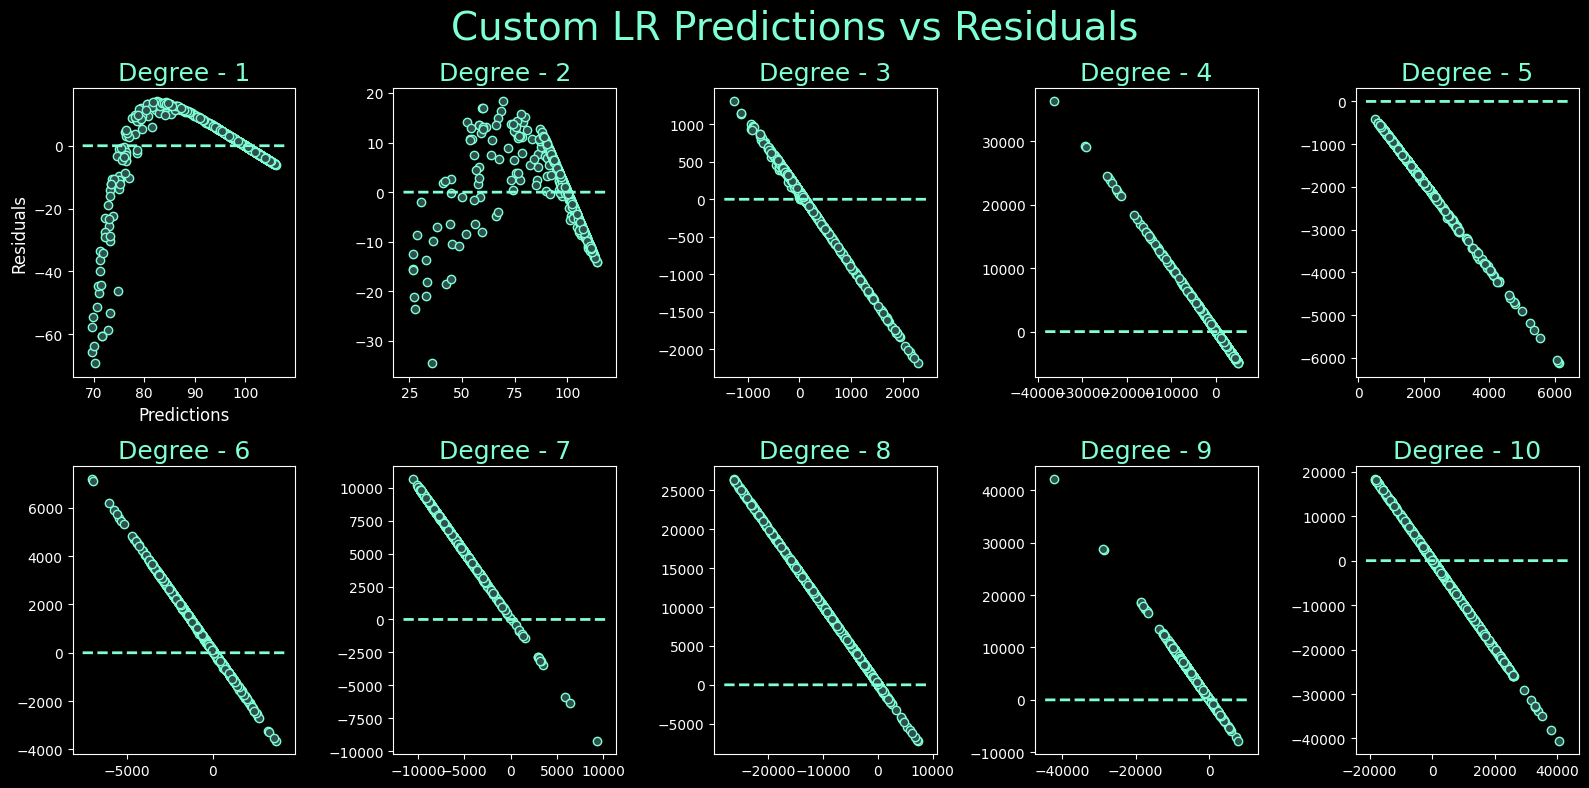

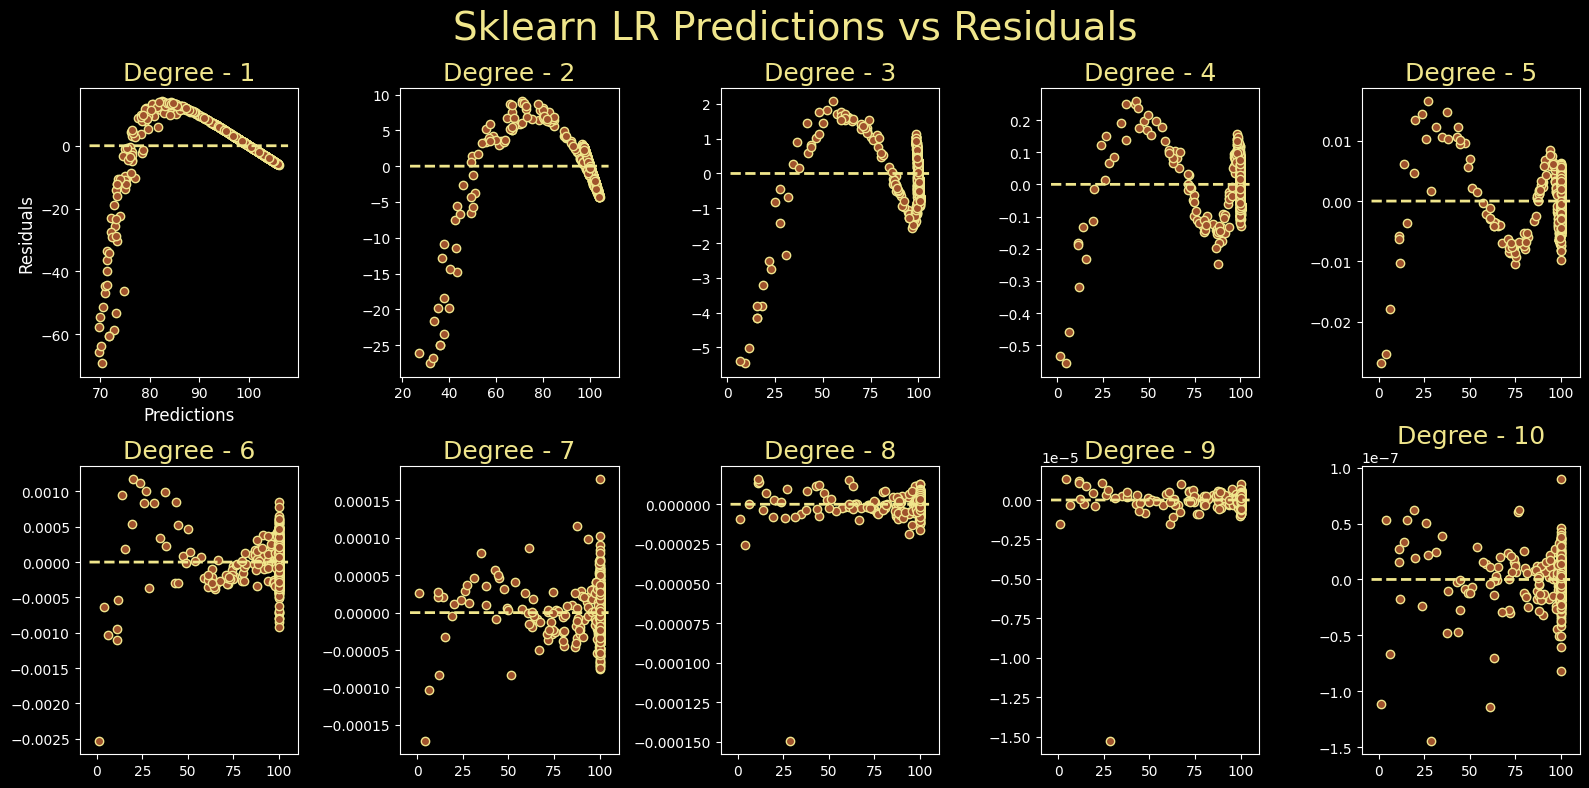

In [26]:
predictions_vs_residuals(models=models)

**Custom Model**:
 - The model violates the linearity and homoscedasticity assumptions across almost all polynomial degrees. When the polynomial degree = 2, residual plot looks the best.

**Sklearn Model**:
 - The model violates the homoscedasticity assumption when degree is less than 6. We see clear patterns. When the polynomial degree is bigger or equal to 6 the residual plots becoming look like uniform distribution showing no visually explicit pattern.

## Compare Models Residuals vs Predictions by Specific Degree 

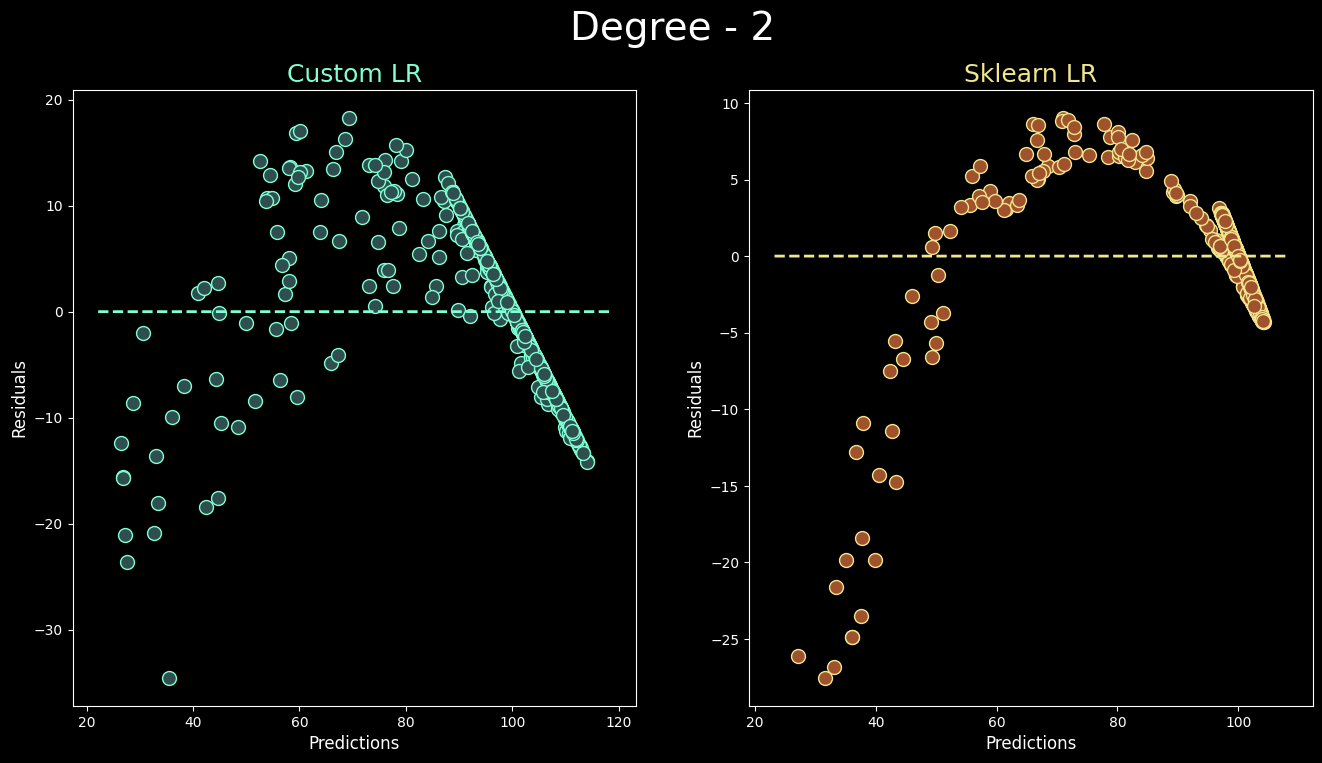

In [27]:
predictions_vs_residuals(models=models, degree=2)

### Normality of Errors

The residuals should be approximately normally distributed. 
This can be checked using a histogram of the residuals.

In [28]:
def residuals_histogram(models, degree=None):
    if degree == None:
        nrows = 2
        ncols = int(degrees/nrows)

        for model in models:
            deg = 0
            fig, ax = plt.subplots(nrows=nrows, ncols=ncols)

            fig.suptitle(t=f"{model["title"]} LR Residuals Histograms", color=model["color"])

            for row in range(nrows):
                for column in range(ncols):

                    # Set x and y labels
                    if deg == 0:
                        ax[row][column].set_xlabel(xlabel="Residuals")
                        ax[row][column].set_ylabel(ylabel="Frequency")
                    
                    # Plot histograms
                    residuals = y_test - model["y_preds"][deg]
                    sns.histplot(residuals, kde=True, color=model["color"], ax=ax[row][column])

                    # Set titles
                    ax[row][column].set_title(label=f"Degree - {deg + 1}", color=model["color"])

                    deg = deg + 1
            plt.tight_layout()
            plt.show()

    else:
        plt.suptitle(t=f"Degree - {degree}")
        for index, model in enumerate(models):
            plt.subplot(1, 2, index + 1)
            plt.title(label=f"{model["title"]} LR Residuals", color=model["color"])
            plt.xlabel(xlabel="Residuals")
            plt.ylabel(ylabel="Frequency")
            residuals = y_test - model["y_preds"][degree - 1]
            sns.histplot(residuals, kde=True, color=model["color"])
        plt.show()

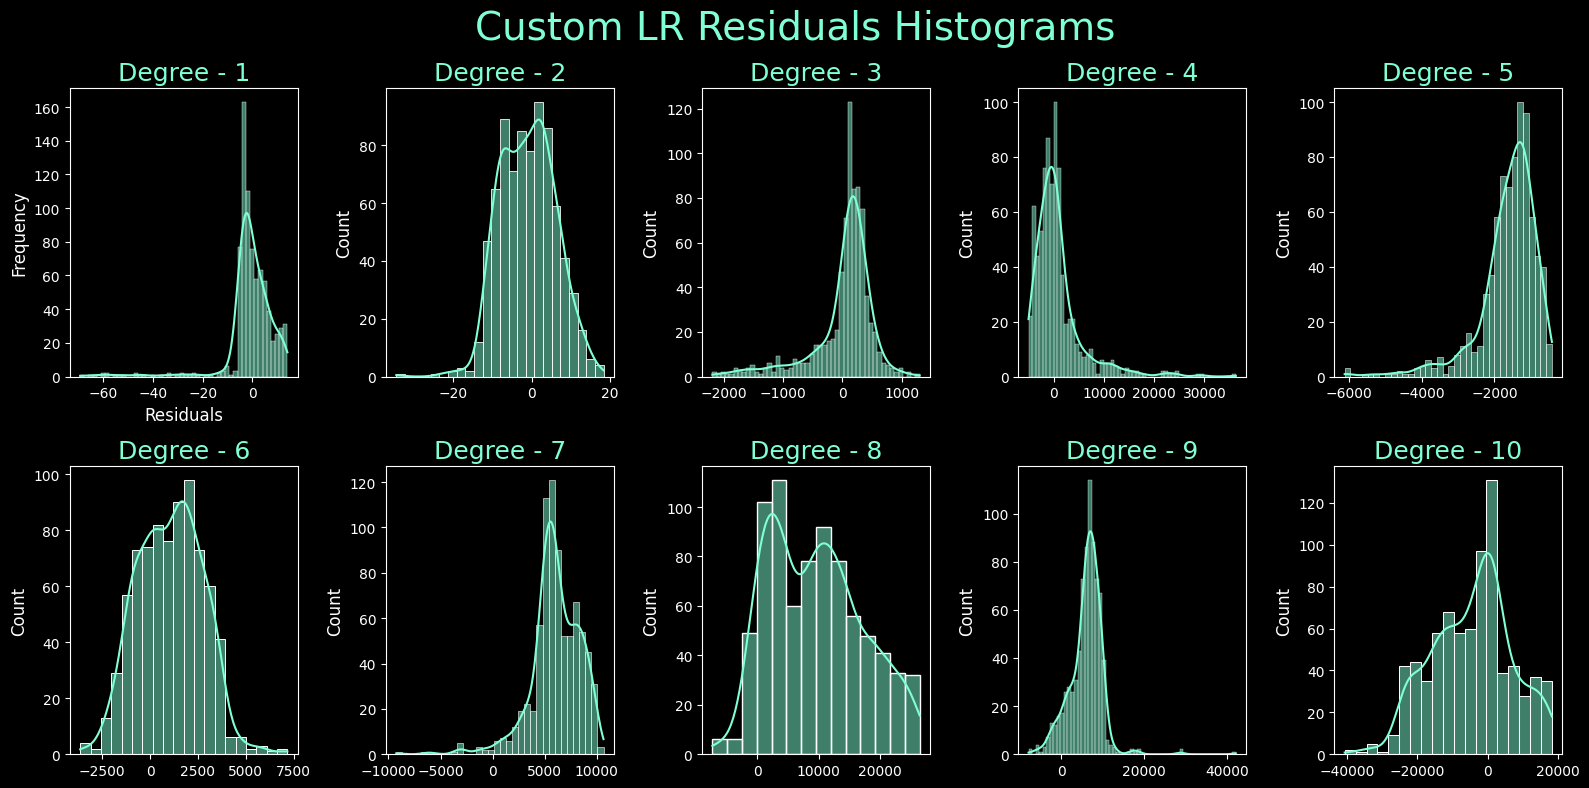

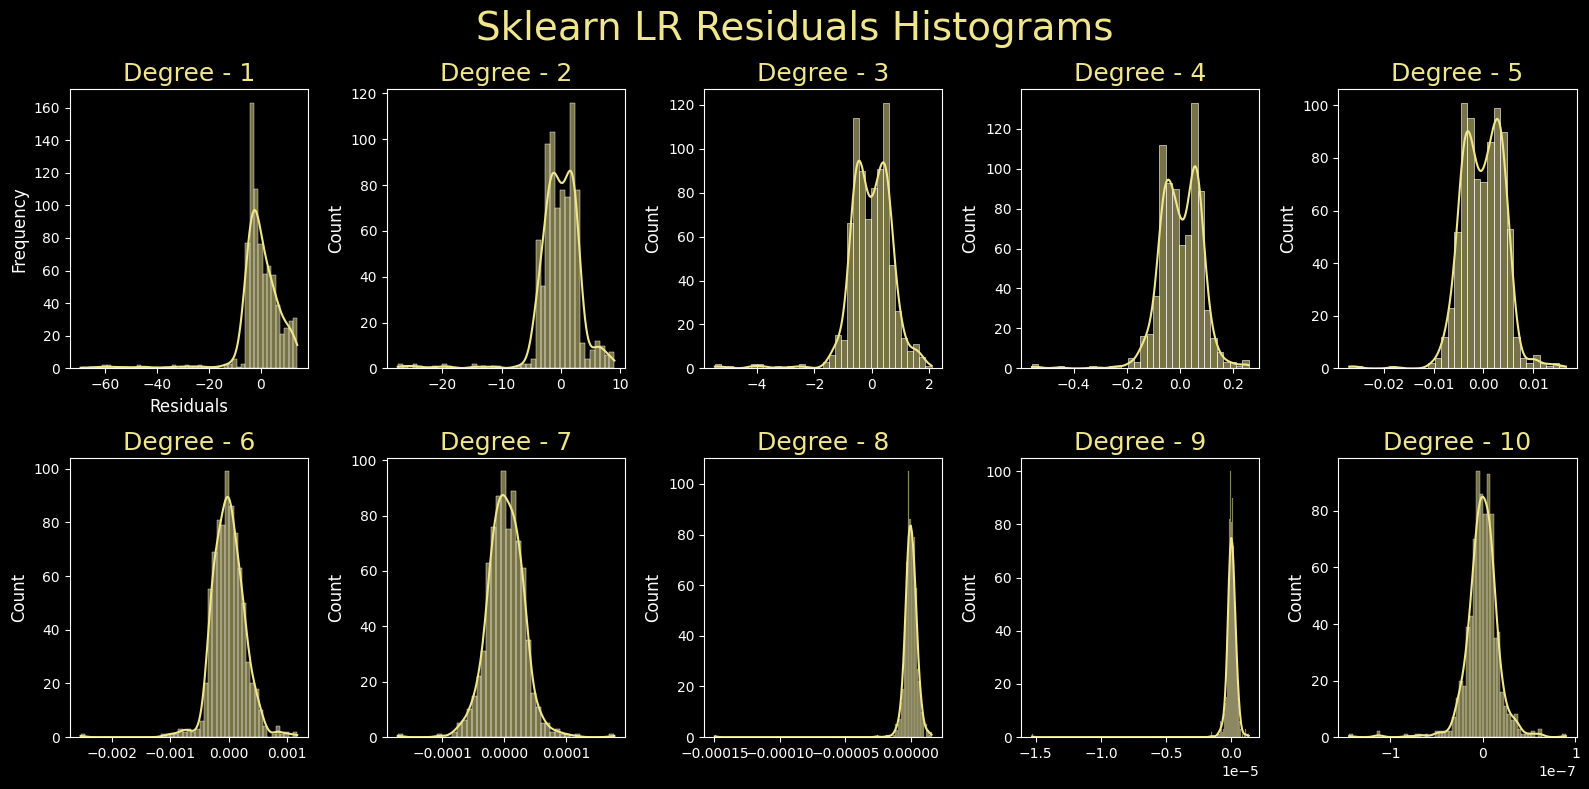

In [29]:
residuals_histogram(models=models)

**Custom Model**:
 - The residual histogram looks the best (Normal Distribution with mean at 0) when the polynomial degree = 2

**Sklearn Model**:
 - The residual histogram looks the best (Normal Distribution with mean at 0) when the polynomial degree = 7.

## Compare Models Residuals Histograms (Normality of Errors) by Specific Degree 

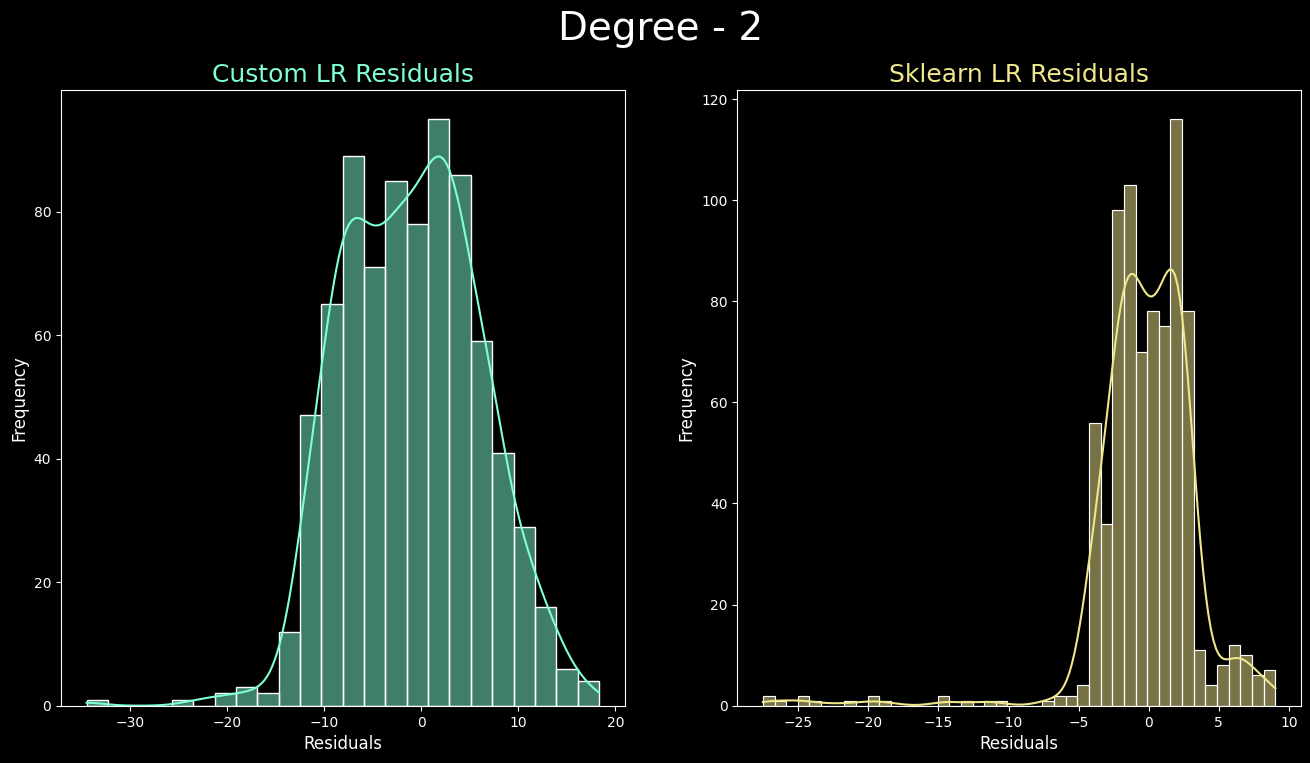

In [30]:
residuals_histogram(models=models, degree=2)

### Multicollinearity

In [31]:
def triangle_heatmap(df, cmap):
    mask = np.triu(np.ones_like(df.drop(columns=["Quality Rating"]).corr(), dtype=bool))
    heatmap = sns.heatmap(data = df.drop(columns=["Quality Rating"]).corr(), mask=mask, annot=True, 
                        annot_kws={"fontsize": 15, "weight": "bold"}, vmax=1, vmin=-1, cmap=cmap)
    heatmap.set_title(label="Triangle Correlation Heatmap between Features", fontsize=25, pad=15)
    heatmap.set_xticklabels(labels=heatmap.get_xticklabels(), fontsize=15, rotation=45)
    heatmap.set_yticklabels(labels=heatmap.get_yticklabels(), fontsize=15, rotation=0);

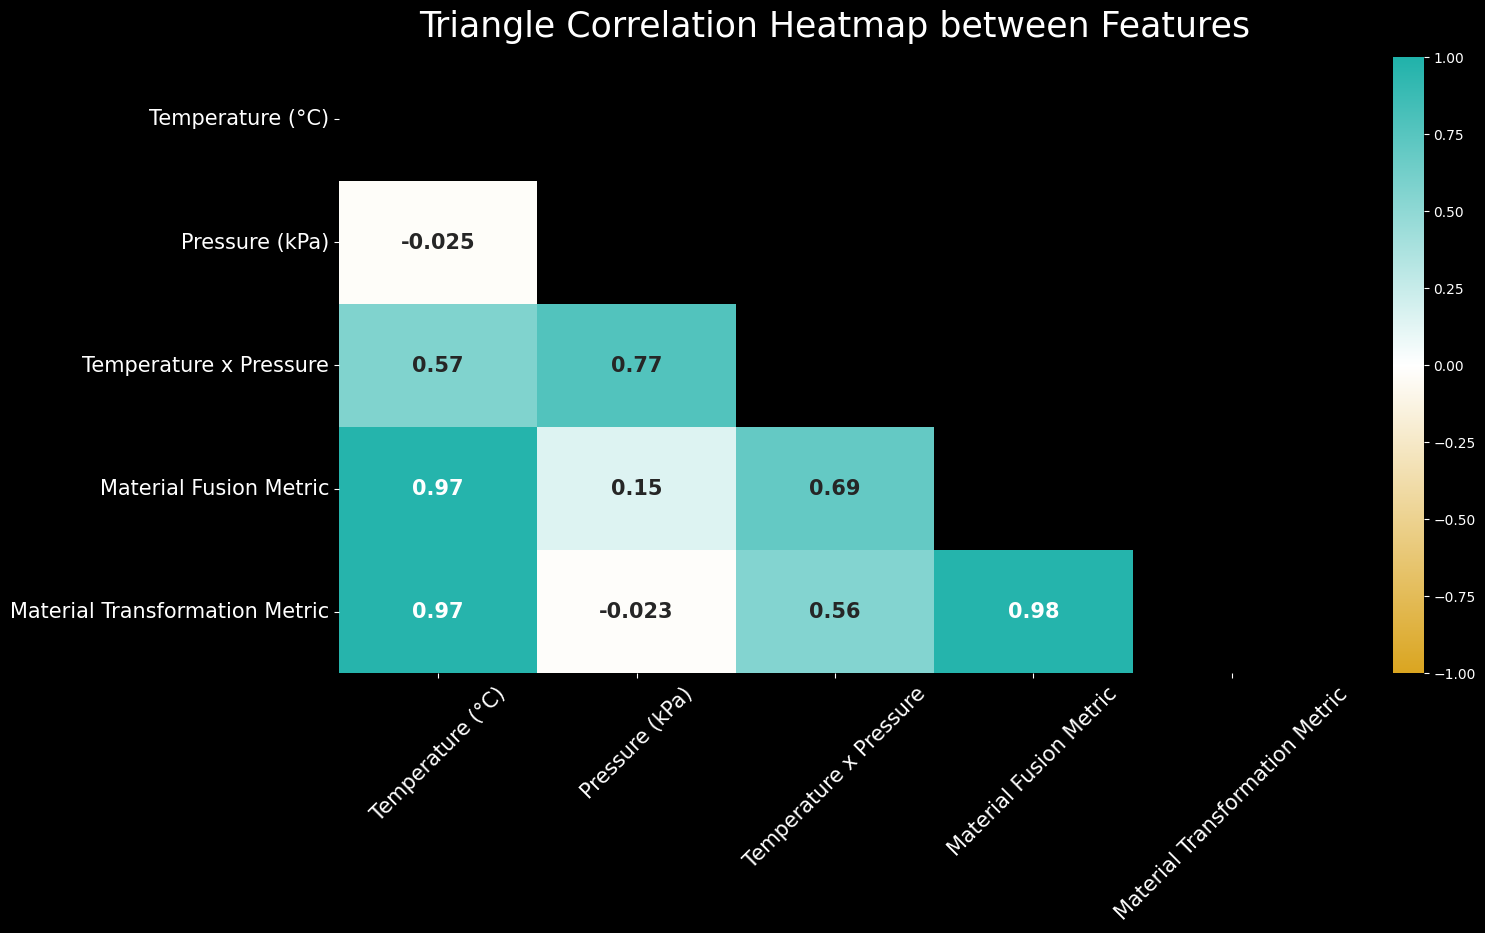

In [32]:
triangle_heatmap(df=df, cmap=cmap)

There is a multicollinearity between features that violates Linear Regression Assumption about No Multicollinearity. **Material Fusion Metric**, **Material Transformation Metric** and **Temperature** are highly correlated (>= 0.97). The solution is to remove two of these features so only one represents all of them. The question is which one should remain?

We will choose that feature that has the highest impact on target variable.

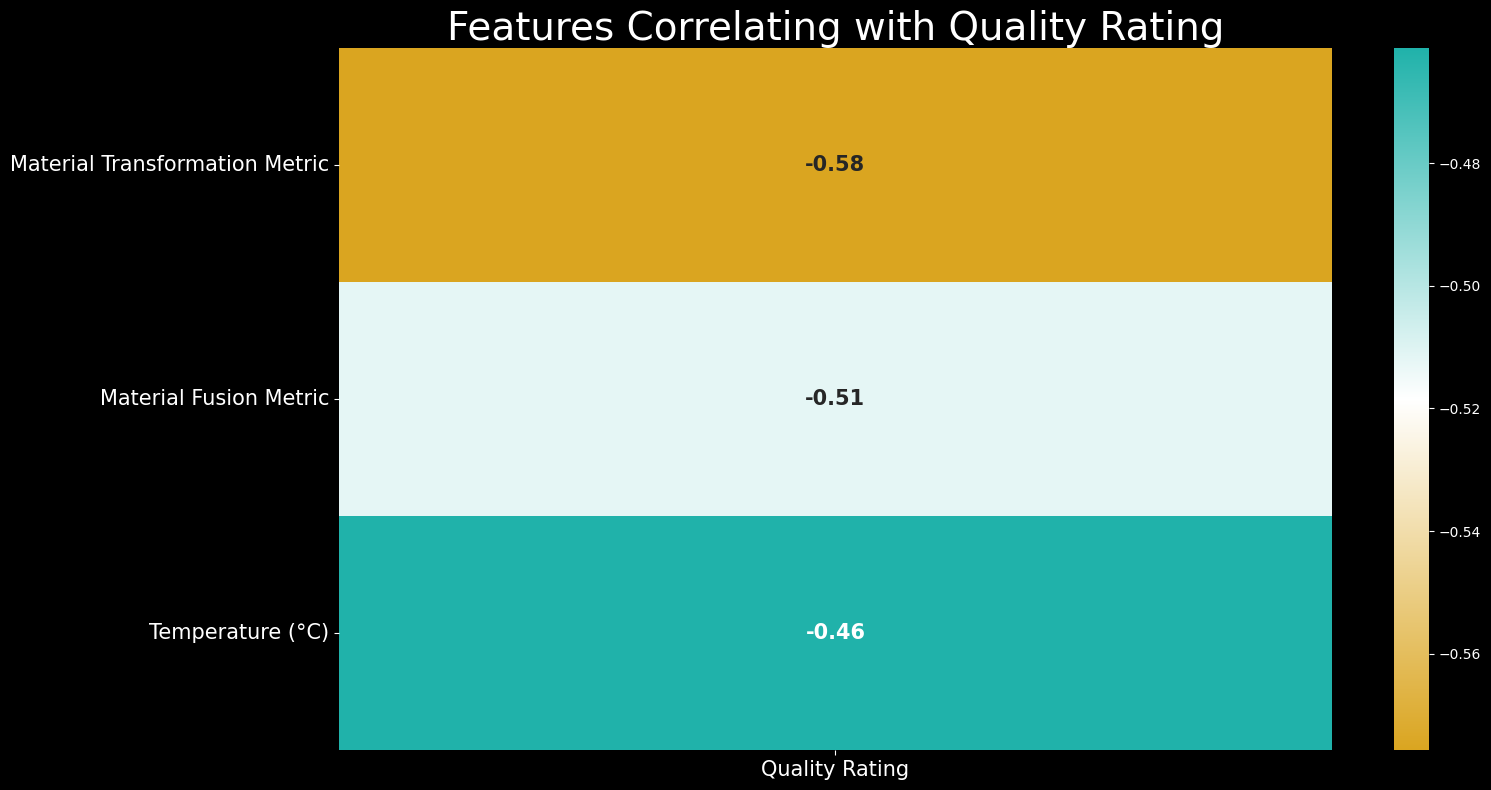

In [33]:
columns = ["Material Fusion Metric", "Material Transformation Metric", "Temperature (°C)", "Quality Rating"]

heatmap_features_target(df=df[columns], cmap=cmap)

**Material Transformation Metric** has the biggest impact on the Target Variable - **Quality Rating**. Thus, we will remove **Temperature** and **Material Fusion Metric**.

In [34]:
df = df.drop(columns=["Material Fusion Metric", "Temperature (°C)"])

print(df.head())
print(df.info())

   Pressure (kPa)  Temperature x Pressure  Material Transformation Metric  Quality Rating
0        8.050855             1688.769167                    9.229576e+06       99.999971
1       15.812068             3842.931469                    1.435537e+07       99.985703
2        7.843130             1729.823314                    1.072839e+07       99.999758
3       23.786089             4970.736918                    9.125702e+06       99.999975
4       15.797812             2918.345014                    6.303792e+06      100.000000
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3957 entries, 0 to 3956
Data columns (total 4 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   Pressure (kPa)                  3957 non-null   float64
 1   Temperature x Pressure          3957 non-null   float64
 2   Material Transformation Metric  3957 non-null   float64
 3   Quality Rating                  3957 non-nul

## Check Collinearity

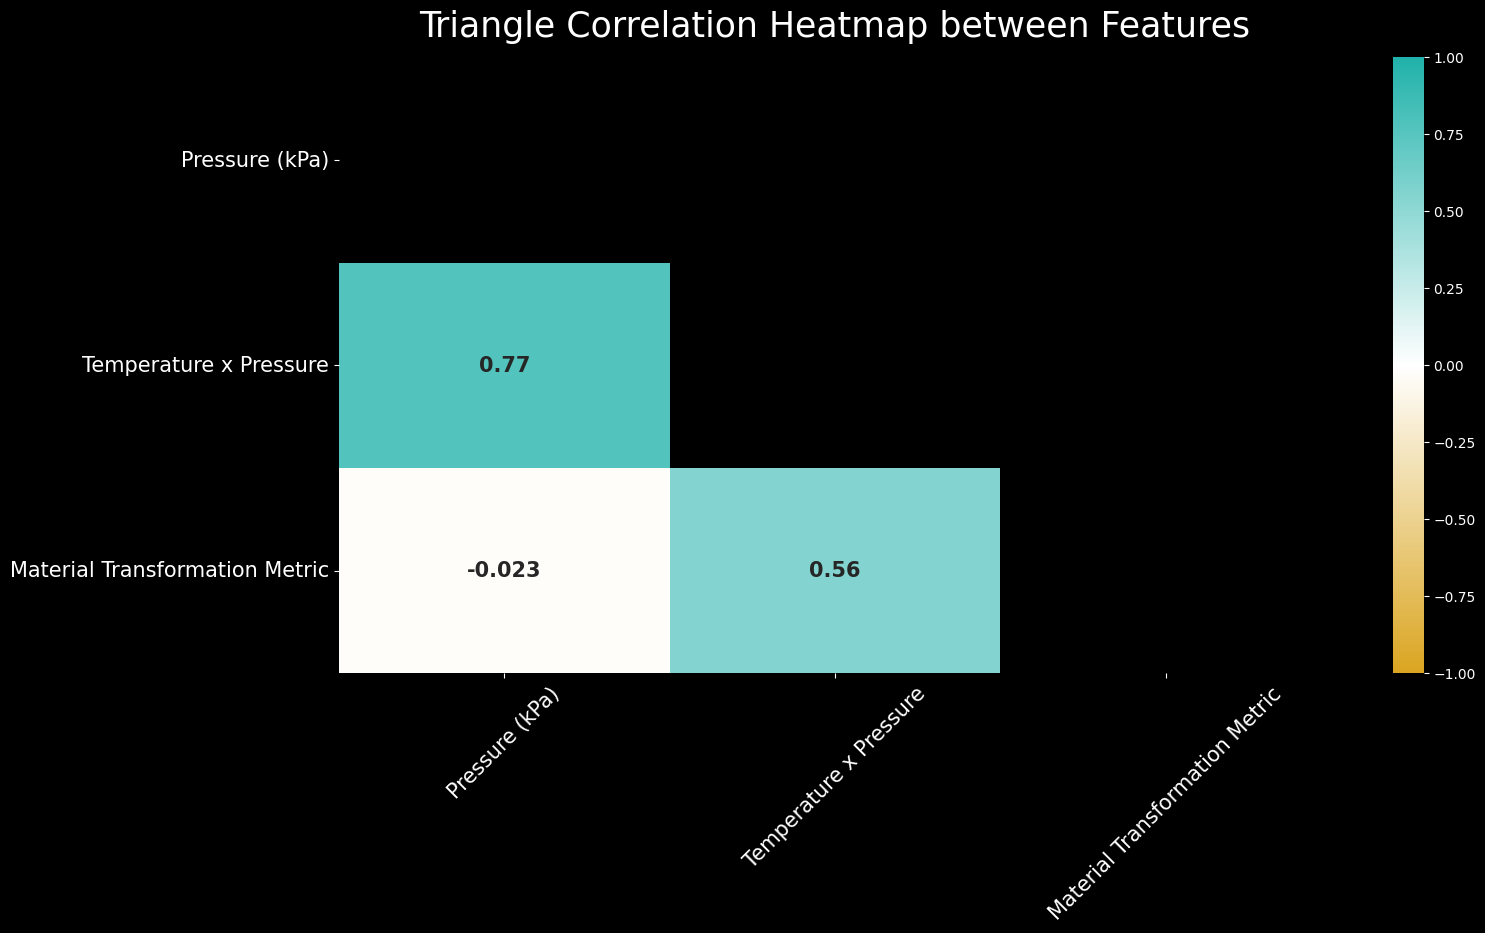

In [35]:
triangle_heatmap(df=df, cmap=cmap)

There is no multicollinearity between features ( all correlations are less than 80%). We can proceed with building a Linear Regreesion again.

## Update Custom and Sklearn models

In [36]:
from Polynomial_Regression.models.update import ModelsUpdate

X = df.drop(columns=["Quality Rating"]).values
y = df["Quality Rating"].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

models_update = ModelsUpdate()
models_update.get_metrics(X_train, X_test, y_train, y_test)
models_update.update_models()
models = models_update.models

## Plot Metrics for Custom and Sklearn models

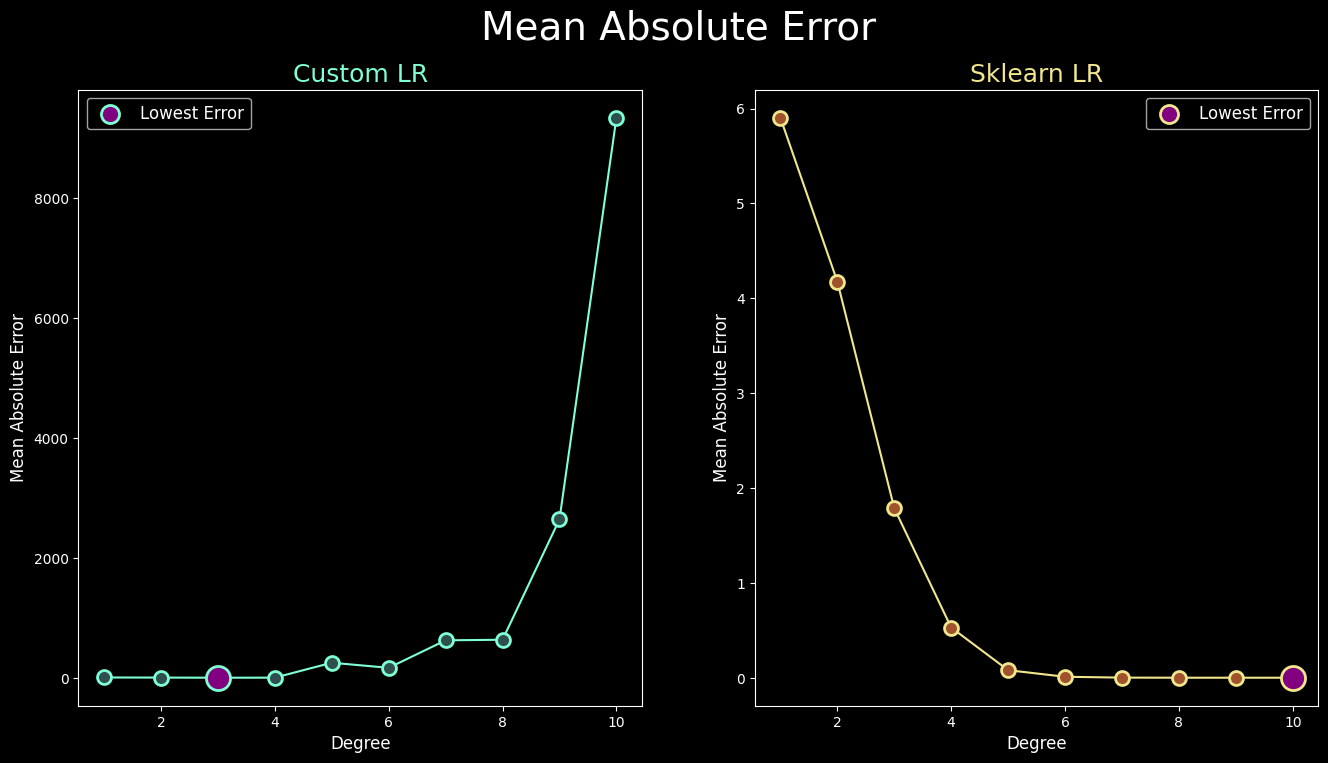

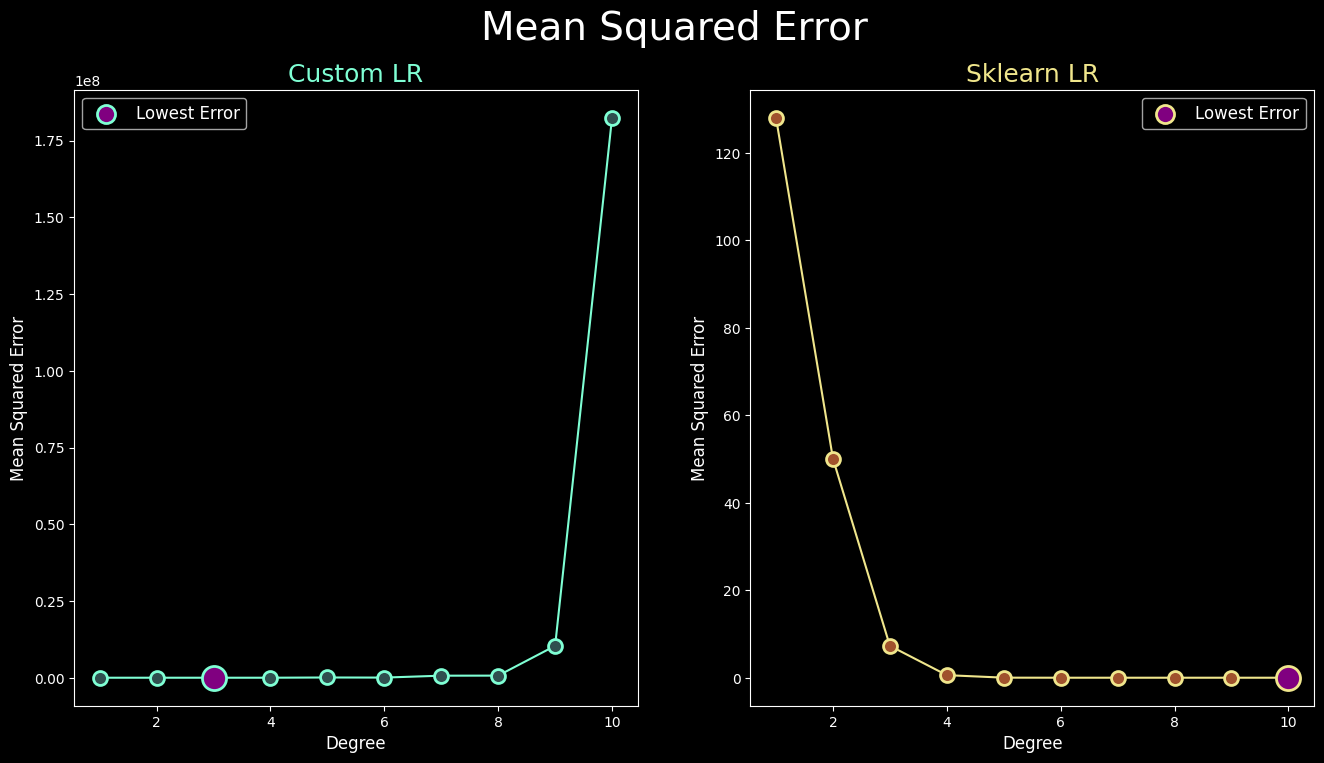

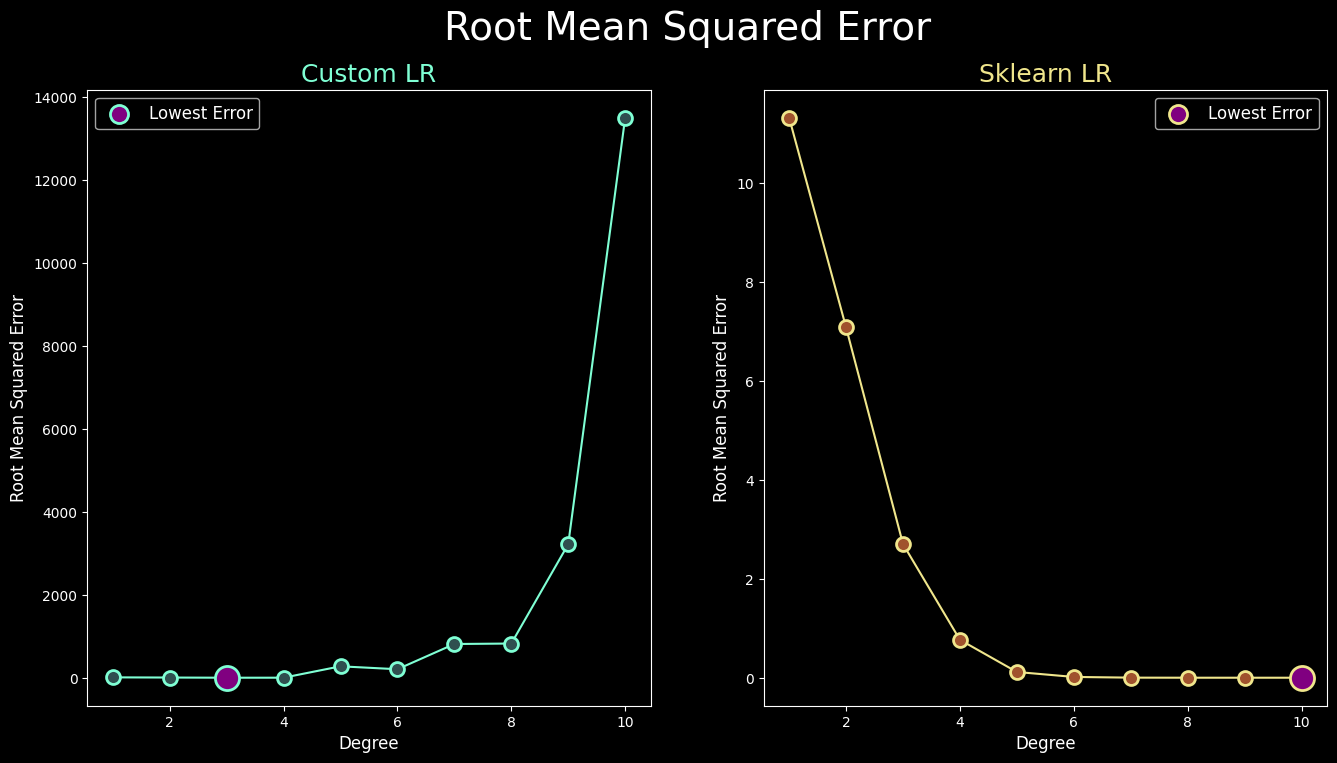

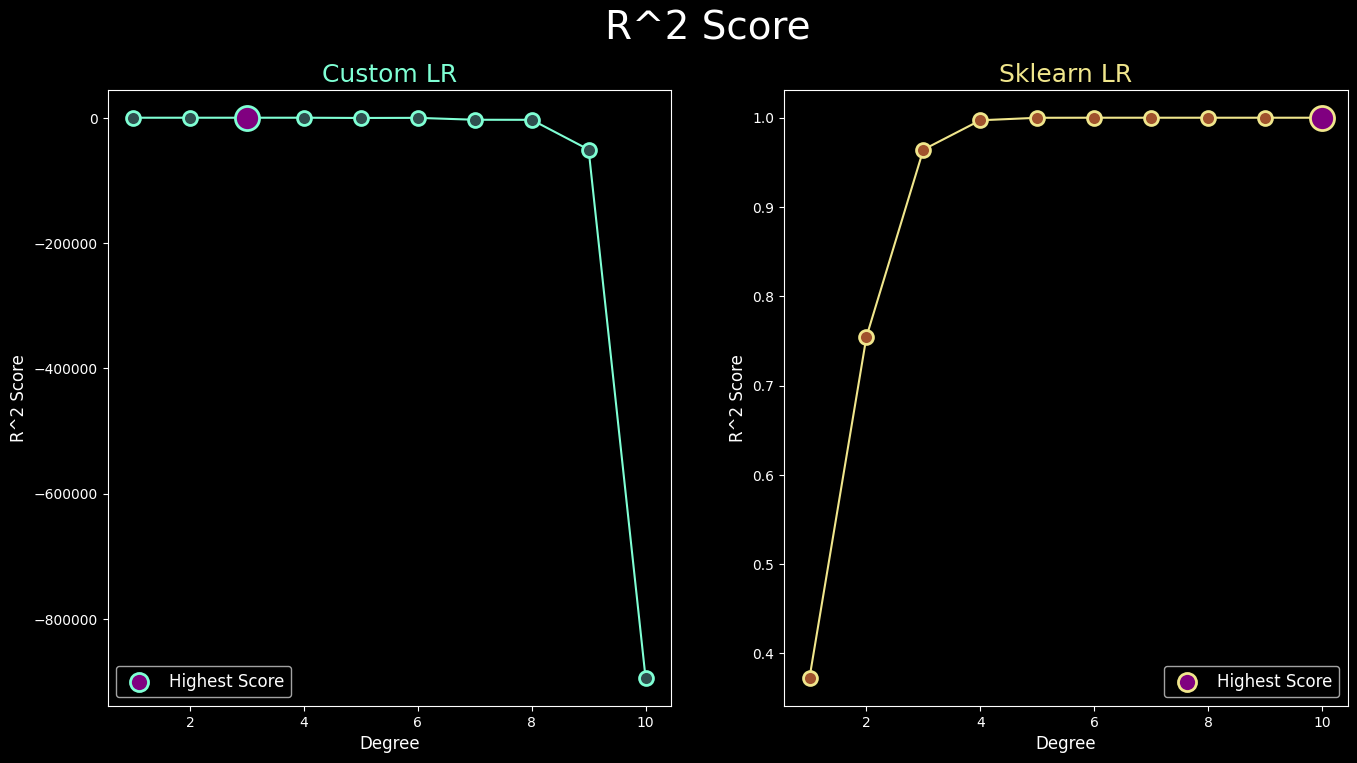

In [37]:
plot_metrics(metrics=metrics, models=models)

**Custom Model**:
 - Lowest errors and highest R^2 score are observed when polynomial degree = 3.

**Sklearn Model**:
 - With an increase of the polynomial degree there is an decrease in errors and increase in R^2 score. After polynomial degree = 5 there is no much difference in errors or R^2 score. Thus, for sake of simplicity and avoiding overfitting, degree = 4 or degree = 5 could be chosen as the best polynomial degrees for this dataset.

## Predictions vs Targets

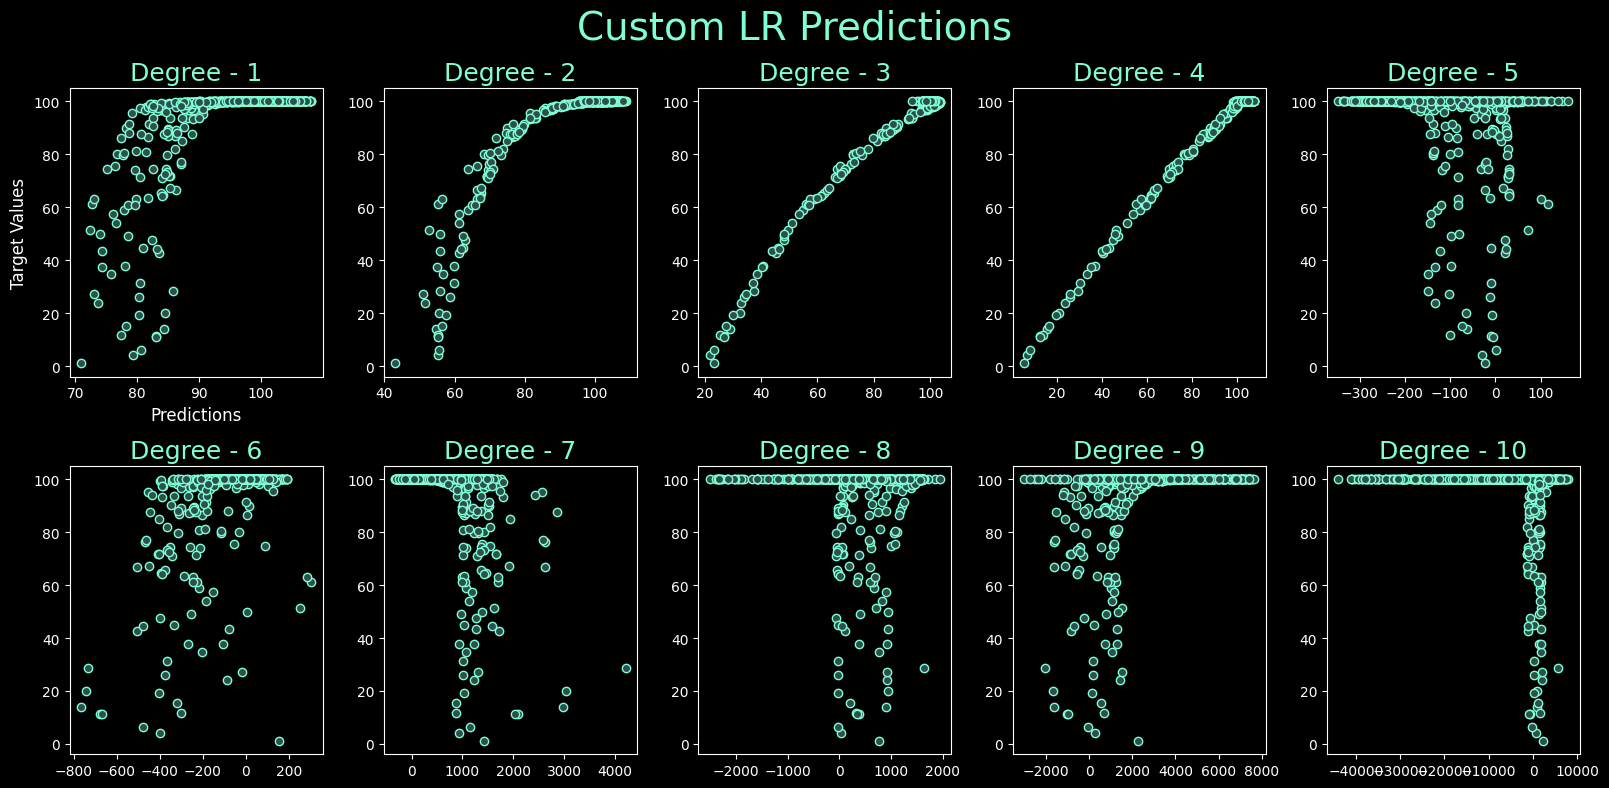

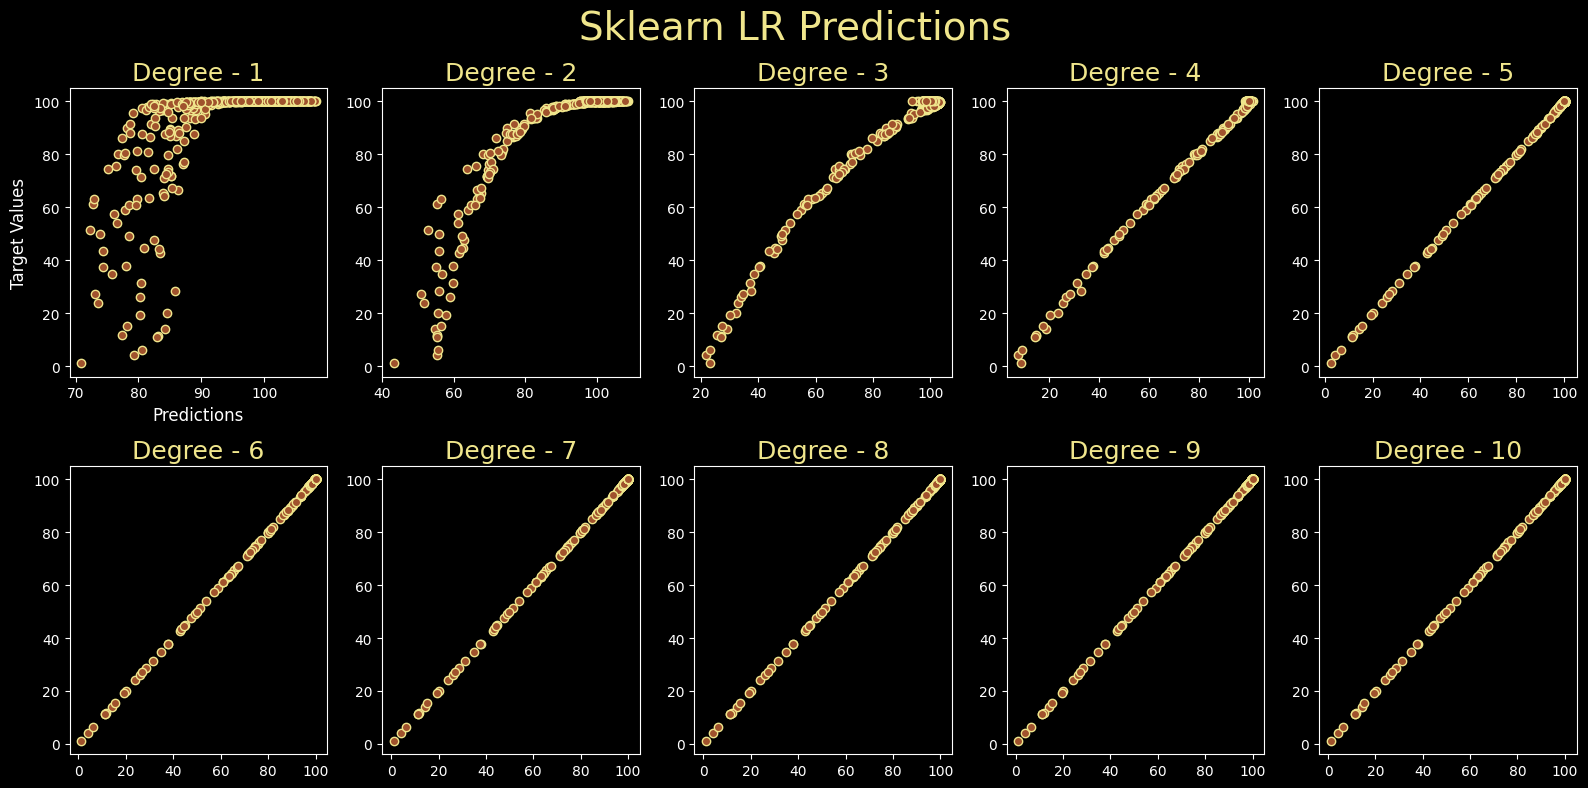

In [38]:
predictions_vs_targets(models=models)

**Custom Model**:
 - Most closest predictions to the actual values are observed when polynomial degree = 4.

**Sklearn Model**:
 - The higher the polynomial degree, the closer model predictions to the actual values are. After polynomial degree = 5 there is no significant difference between actual values and predictions of the model. Thus, for sake of simplicity and avoiding overfitting, degree = 4 or degree = 5 could be chosen as the best polynomial degree for this dataset.

## Predictions vs Residuals

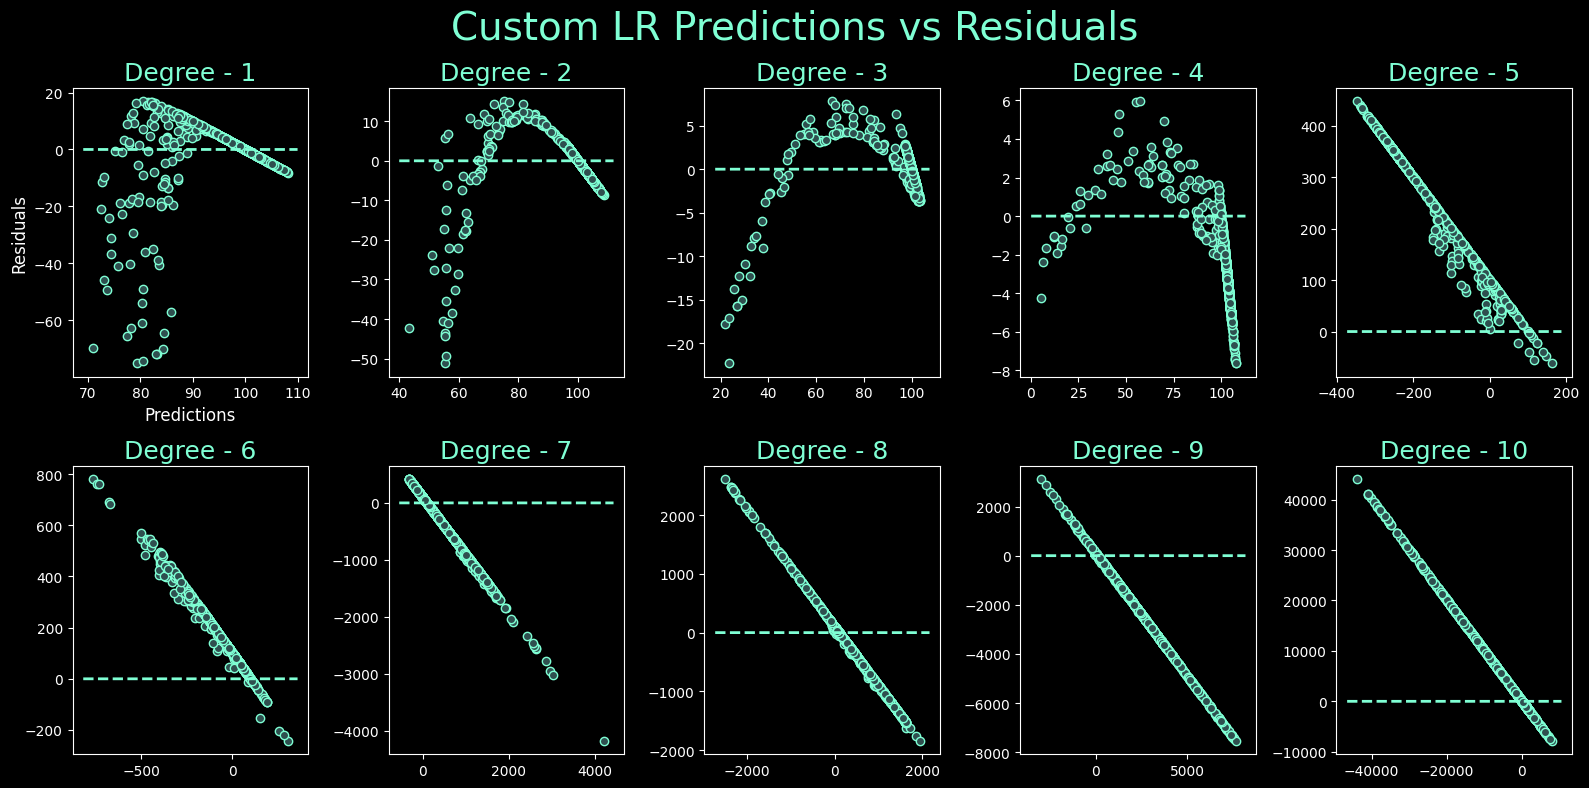

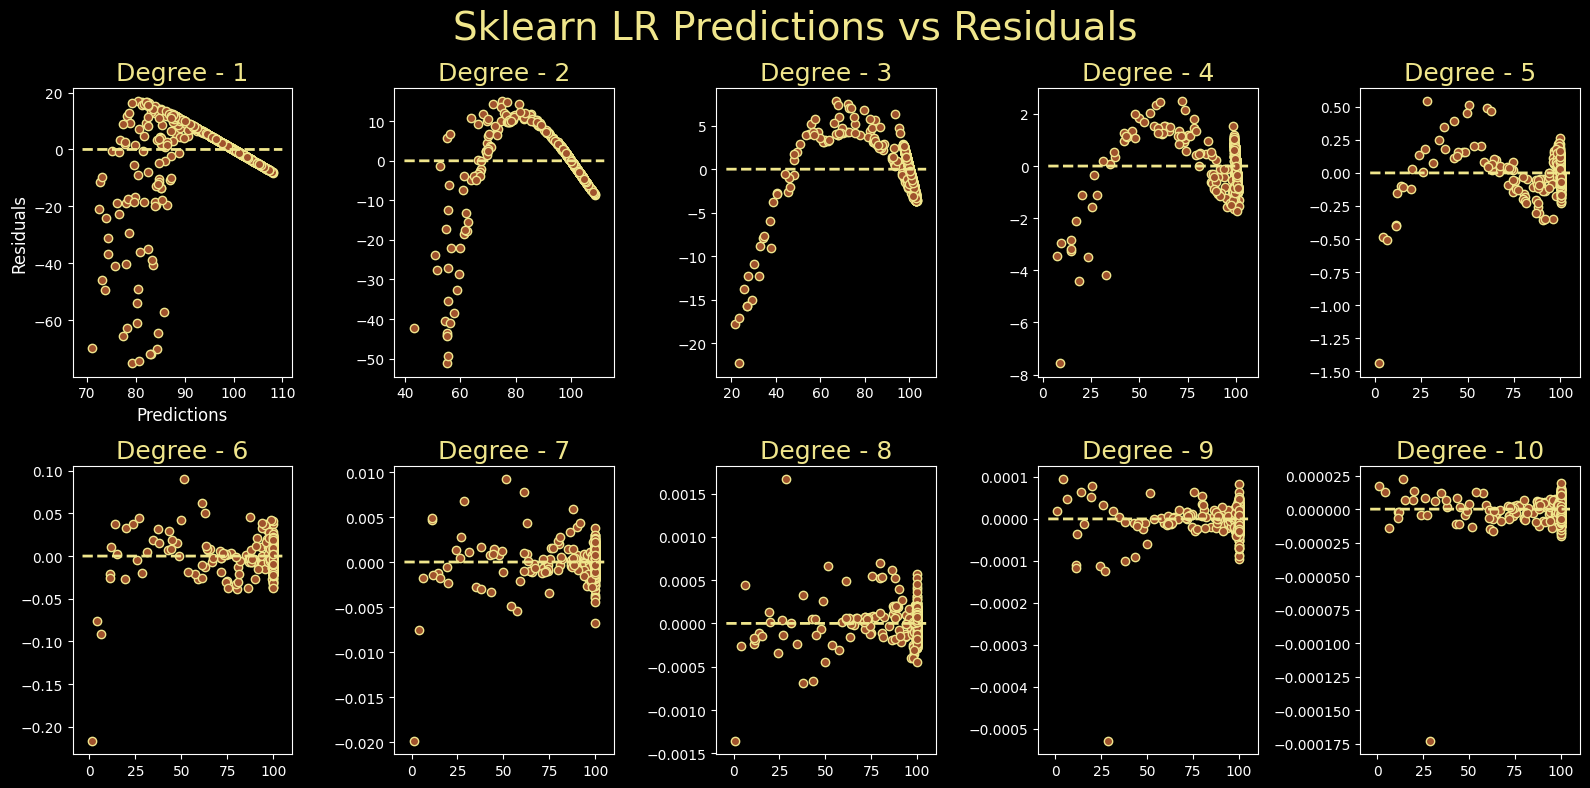

In [39]:
predictions_vs_residuals(models=models)

**Custom Model**:
 - The model violates the linearity and homoscedasticity assumptions across almost all polynomial degrees. When the polynomial degree = 4, residual plot looks the best.

**Sklearn Model**:
 - The model violates the homoscedasticity assumption when degree is less than 6. We see clear patterns. When the polynomial degree is bigger or equal to 6 the residual plots becoming look like uniform distribution showing no visually explicit pattern.

## Residuals Histogram

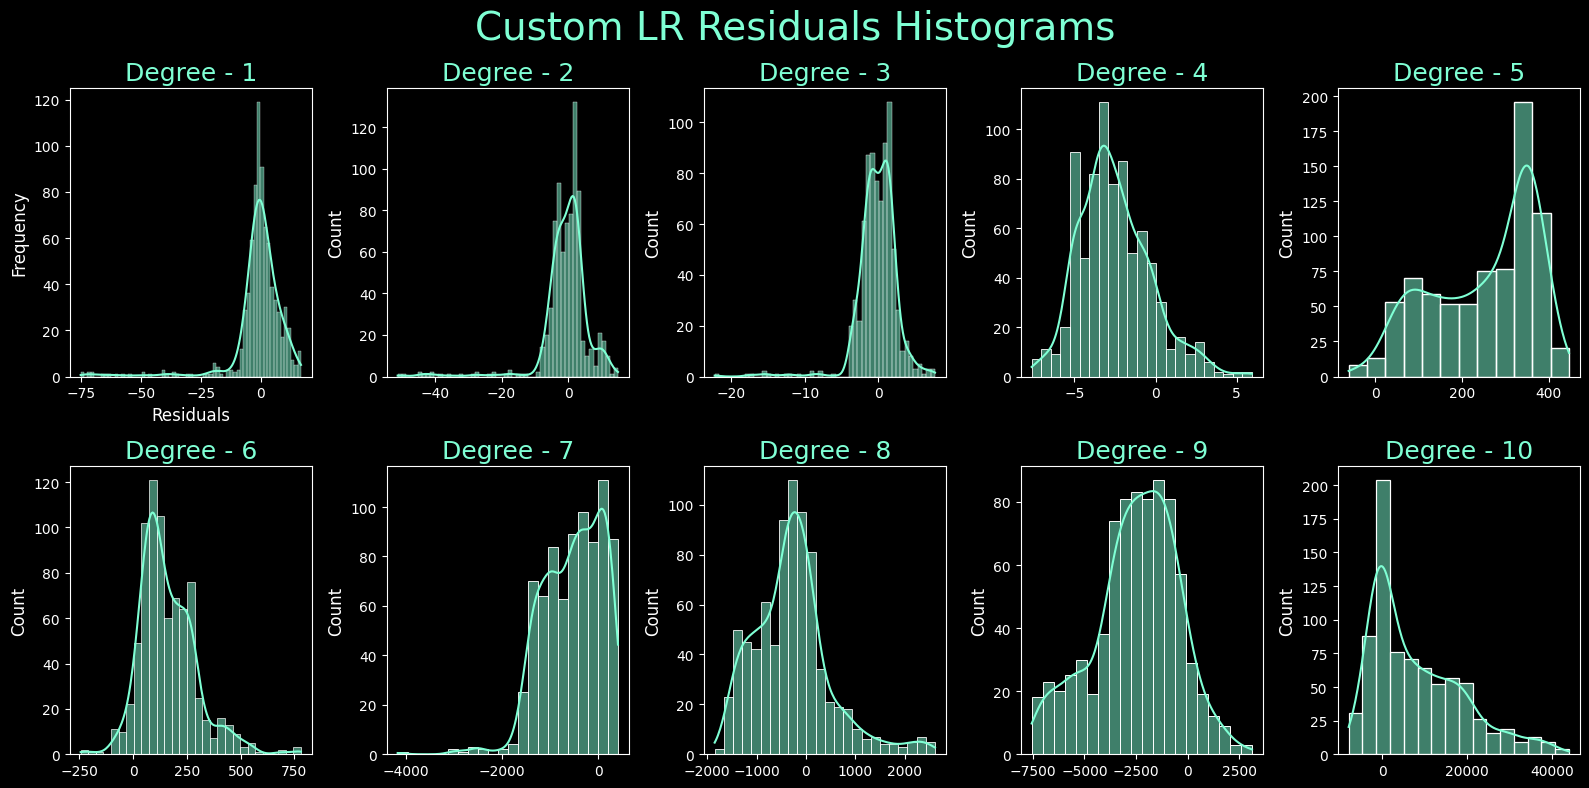

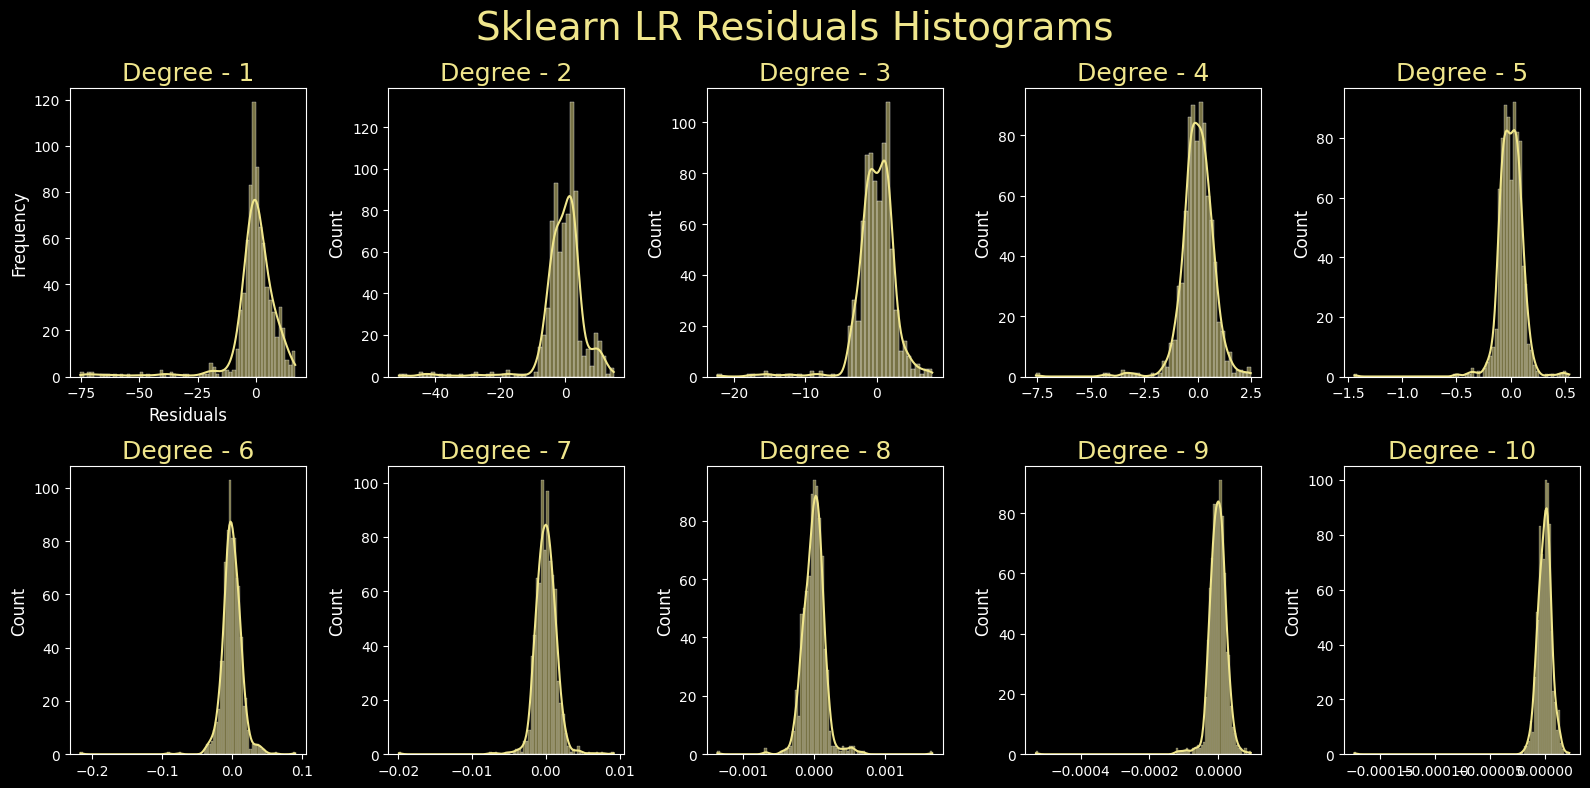

In [40]:
residuals_histogram(models=models)

**Custom Model**:
 - The residual histogram looks the best (Normal Distribution with mean at 0) when the polynomial degree = 4

**Sklearn Model**:
 - The residual histogram looks the best (Normal Distribution with mean at 0) when the polynomial degree = 8.

Based on Linear Regression Metrics and Assumptions Analysis the best polynomial degree for the **Custom** Linear Regression Model is **3**, and for the **Sklearn Model - 5**.

In [41]:
data = []
for model in models:
    model_data = {}
    degree = 3 if model["title"] == "Custom" else 5
    model_data["model"] = model["title"]
    model_data["MAE"] = model["maes"][degree - 1]
    model_data["MSE"] = model["mses"][degree - 1]
    model_data["RMSE"] = model["rmses"][degree - 1]
    model_data["R2"] = model["r2"][degree - 1]

    data.append(model_data)

## Show dataframe of final results

In [42]:
metrics_frames = []
for model_data in data:
    metrics_frames.append(pd.DataFrame(data=model_data, index=[0]))

result = pd.concat(metrics_frames).reset_index(drop=True)
result

model       MAE       MSE      RMSE        R2
0   Custom  1.786818  7.294667  2.700864  0.964268
1  Sklearn  0.079532  0.013456  0.116002  0.999934

*Note: Difference between Custom model and Sklearn model performance*:

- *Numerical Stability*

sklearn implementations are designed to be numerically stable, meaning they handle floating-point operations very efficiently, avoiding issues like overflow or underflow. My custom model might not handle these cases as effectively.

- *Precision*

The creation of polynomial features in my custom implementation might not be as precise or efficient as sklearn's PolynomialFeatures. Differences in floating-point precision can lead to significant discrepancies when working with higher-degree polynomials.

- *Handling of Edge Cases*

sklearn models are robust to various edge cases, such as multicollinearity, near-singular matrices, etc. My custom model might not handle these cases as gracefully, leading to poorer performance.